# Initializing stuf

In [13]:
import numpy as np
from qsweepy import sweep_extras
from qsweepy.fitters import *
from qsweepy.fitters.multiqubit_spectra import *
from qsweepy.ponyfiles import *
import qutip
import resonator_tools
from matplotlib import pyplot as plt
import traceback
%matplotlib inline
from resonator_tools import circuit
from scipy.interpolate import interp1d
from scipy.optimize import least_squares
from tqdm import tqdm
import pandas as pd
#params['J1']


In [5]:
sample_name = '11qubits_021119_2'
sample_name_old = '11qubits_021119'
db = database.MyDatabase(host='10.20.61.31')

sweeper = sweep_extras.Sweeper(db, sample_name=sample_name)
exdir_db_inst = exdir_db.Exdir_db(db=db, sample_name=sample_name)
exdir_db_inst_old = exdir_db.Exdir_db(db=db, sample_name=sample_name_old)

#exdir_db_inst.old_prefix = 'd:\\data'
#exdir_db_inst.new_prefix = '\\\\10.20.61.31\\data'

params = load_parameters_dict(exdir_db_inst)

In [6]:
num_qubits = 11
num_levels_per_qubit = 3
f1 = 3.8
J1 = 0.0145
J2 = 0.0045
EC = params['EC']/1e9
H01 = np.asarray([[0,0,0],[0,f1,0],[0,0,2*f1-EC,]])
H01 = qutip.Qobj(H01)

#coil_qubits = {'1':20, '2':18, '3':16, '4':13, '5':12, '6':10, '7':8, '8':6, '9':4, '10':2, '11':0}
from collections import OrderedDict
coil_qubits = OrderedDict({20:'1', 18:'2', 16:'3', 13:'4', 12:'5', 10:'6', 8:'7', 6:'8', 4:'9', 2:'10', 0:'11'})
params['qubits'] = params['EJ1'].keys()
inductance_matrix = build_inductance_matrix(params)

H01

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.    0.    0.   ]
 [0.    3.8   0.   ]
 [0.    0.    7.445]]

## Simulation routines

In [5]:
def simulate_non_driven_frequencies(num_qubits, qubit_frequencies, J1, J2, threshold=0.02, threshold_qubit_id=0):
    # diagonal
    H0i = []
    for qubit_id in range(num_qubits):
        Hi = []
        for qubit_id2  in range(num_qubits):
            if qubit_id == qubit_id2:
                H01 = qutip.Qobj(np.diag([0, qubit_frequencies[qubit_id], qubit_frequencies[qubit_id]*2-params['EC']]))
                Hi.append(H01)
            else:
                Hi.append(qutip.qeye(num_levels_per_qubit))
        H0i.append(qutip.tensor(*Hi))
    H0 = sum(H0i)
    #interaction
    Hii = []
    for qubit_id in range(num_qubits):
        Hi = []
        for qubit_id2  in range(num_qubits):
            ai = qutip.destroy(3)
            if qubit_id == qubit_id2:
                if qubit_id % 2:
                    J = J2
                else:
                    J = J1
                Hi.append((ai+ai.dag())*J*np.sqrt(qubit_frequencies[qubit_id]))
            elif qubit_id + 1 == qubit_id2:
                Hi.append((ai+ai.dag())*np.sqrt(qubit_frequencies[qubit_id+1]))
            else:
                Hi.append(qutip.qeye(num_levels_per_qubit))
        Hii.append(qutip.tensor(*Hi))
    Hint = sum(Hii)
    
    threshold_operator = []
    for qubit_id in range(num_qubits):
        if qubit_id == threshold_qubit_id:
            threshold_operator.append(qutip.Qobj([[0,0,0],[0,1,0],[0,0,2]]))
        else:
            threshold_operator.append(qutip.qeye(3))
    threshold_operator = qutip.tensor(*threshold_operator)
    
    Hnd = Hint+H0
    sparse = num_qubits != 1
    vals, vecs = Hnd.eigenstates(sparse=sparse, sort='low', eigvals=num_qubits*(num_qubits+3)//2+1)
    vals_visible = []
    vecs_visible = []
    for val, vec in zip(vals, vecs):
        #if qutip.expect(threshold_operator, vec) > threshold:
        vals_visible.append(val)
        vecs_visible.append(vec)
    
    return vals_visible, vecs_visible

## simulating resonance frequencies using full 11-qubit Hamiltonian diagonalization

$n$ qubit tuned into 3.8 GHz resonance, the rest are set in frequency space as in the measurement metadata files or exciting from qubit 1 and reading out qubit 1

In [33]:
# simulate 11 qubits
min_num_qubits = 1
max_num_qubits = 11
simulation_qubit_num = 11
zoom_qubit_id = 6
f01_simulations = []
f02h_simulations = []
wavefunctions = None
eigenvectors = []
qubit_frequencies_raw = []

for num_qubits in tqdm(range(min_num_qubits, max_num_qubits+1)):
    coil_voltages = {}
    m=exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                             metadata={'num_resonant_qubits': num_qubits,
                                                       'resonator_id':'1',
                                                       'ex_qubit': '1',
                                                       'pump_power': '-20.0'})

    for fig_id, power in enumerate(['-20.0', '0.0']):
        for coil, voltage in m.metadata.items():
            if coil[:6] == 'NNDAC-':
                if int(coil[6:]) in coil_qubits.keys():
                    coil_voltages[coil_qubits[int(coil[6:])]] = float(voltage)
        coil_voltages_vec = [coil_voltages[qubit_id] for qubit_id in coil_qubits.values()]

    qubit_frequencies = []
    for qubit_id_, qubit_id in enumerate(coil_qubits.values()):
        qubit_flux = (inductance_matrix@coil_voltages_vec)[qubit_id_]+params['phi0'][qubit_id]
        qubit_frequencies.append(fqbare(params['EJ1'][qubit_id], params['EJ2'][qubit_id], params['EC'], qubit_flux))

    simulation_qubit_num = num_qubits+1 if num_qubits < max_num_qubits else max_num_qubits
    #simulation_qubit_num = num_qubits
    vals, vecs_ = simulate_non_driven_frequencies(simulation_qubit_num, qubit_frequencies, J1, J2)
    eigenvectors.append(vecs_)
    f01 = vals[1:simulation_qubit_num+1]-vals[0]
    f01_thermal = np.reshape(vals[1:simulation_qubit_num+1], (-1, 1)) - vals[simulation_qubit_num+1:]
    first_qubit_op = qutip.tensor((qutip.destroy(3)+qutip.destroy(3).dag()), *[qutip.qeye(3)]*10)
    #f01_thermal_jump_probabilities  = np.zeros((simulation_qubit_num, len(vals)-simulation_qubit_num-1), complex)
    #for i, state_i in enumerate(vecs_[1:simulation_qubit_num]):
    #    for j, state_j in enumerate(vecs_[simulation_qubit_num+1:]):
    #        f01_thermal_jump_probabilities[i,j] = first_qubit_op.matrix_element(state_i, state_j)
    #f01_thermal_elements = np.conj(np.asarray(vecs_[1:simulation_qubit_num]))@first_qubit_op@np.asarray(vecs_[simulation_qubit_num+1:])
    f02h = np.asarray(vals[simulation_qubit_num+1:]-vals[0])/2
    f01_simulations.append(f01)
    f02h_simulations.append(f02h)
    qubit_frequencies_raw.append(qubit_frequencies)
    wavefunctions = vecs_

 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:03<00:03,  1.66it/s]


KeyboardInterrupt: 

### Raw qubit frequencies in the measurements (from metadata)

In [34]:
qubit_frequencies_raw

[[3800047975.9824896,
  3334416571.3084135,
  4036617875.6013045,
  3942260071.0353312,
  3915024786.8138676,
  3854182176.49727,
  4052194631.1379004,
  3949203471.240704,
  4032994599.3661165,
  3929561802.8725624,
  3974291171.1587725],
 [3800065151.580895,
  3800003815.6398745,
  4036617892.113132,
  3942260069.343192,
  3915024786.8138676,
  3854182176.49727,
  4052194631.1379004,
  3949203471.240704,
  4032994599.3661165,
  3929561802.8725624,
  3974291171.1587725],
 [3800067221.6510067,
  3799992014.6227927,
  3800193517.693963,
  3329129471.947695,
  3915024793.8255057,
  3854182174.797535,
  4052194631.1379004,
  3949203471.240704,
  4032994599.3661165,
  3929561802.8725624,
  3974291171.1587725],
 [3800067221.6510067,
  3799989081.674645,
  3799862728.32429,
  3800041288.7733026,
  3300042811.7322326,
  3854182141.5915914,
  4052194630.528023,
  3949203471.240704,
  4032994599.3661165,
  3929561802.8725624,
  3974291171.1587725],
 [3800067221.6510067,
  3799989081.674645,
  3

In [ ]:
## Draing picture with enlarged 

In [12]:
# simulate 11 qubits
min_num_qubits = 1
max_num_qubits = 11
simulation_qubit_num = 11
zoom_qubit_id = 6
edge_f01_simulations = []
edge_f02h_simulations = []
edge_wavefunctions = None
edge_eigenvectors = []
edge_qubit_frequencies_raw = []

for num_qubits in tqdm(range(min_num_qubits, max_num_qubits+1)):
    coil_voltages = {}
    m=exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                                 metadata={'num_resonant_qubits': num_qubits,
                                                           'resonator_id':'11',
                                                           'ex_qubit': '11',
                                                           'pump_power': '-10.0'})

    for fig_id, power in enumerate(['-20.0', '0.0']):
        for coil, voltage in m.metadata.items():
            if coil[:6] == 'NNDAC-':
                if int(coil[6:]) in coil_qubits.keys():
                    coil_voltages[coil_qubits[int(coil[6:])]] = float(voltage)
        coil_voltages_vec = [coil_voltages[qubit_id] for qubit_id in coil_qubits.values()]

    qubit_frequencies = []
    for qubit_id_, qubit_id in enumerate(coil_qubits.values()):
        qubit_flux = (inductance_matrix@coil_voltages_vec)[qubit_id_]+params['phi0'][qubit_id]
        qubit_frequencies.append(fqbare(params['EJ1'][qubit_id], params['EJ2'][qubit_id], params['EC'], qubit_flux))

    simulation_qubit_num = num_qubits+1 if num_qubits < max_num_qubits else max_num_qubits
    #simulation_qubit_num = num_qubits
    vals, vecs_ = simulate_non_driven_frequencies(simulation_qubit_num, qubit_frequencies, J1, J2)
    eigenvectors.append(vecs_)
    f01 = vals[1:simulation_qubit_num+1]-vals[0]
    f01_thermal = np.reshape(vals[1:simulation_qubit_num+1], (-1, 1)) - vals[simulation_qubit_num+1:]
    first_qubit_op = qutip.tensor((qutip.destroy(3)+qutip.destroy(3).dag()), *[qutip.qeye(3)]*10)
    #f01_thermal_jump_probabilities  = np.zeros((simulation_qubit_num, len(vals)-simulation_qubit_num-1), complex)
    #for i, state_i in enumerate(vecs_[1:simulation_qubit_num]):
    #    for j, state_j in enumerate(vecs_[simulation_qubit_num+1:]):
    #        f01_thermal_jump_probabilities[i,j] = first_qubit_op.matrix_element(state_i, state_j)
    #f01_thermal_elements = np.conj(np.asarray(vecs_[1:simulation_qubit_num]))@first_qubit_op@np.asarray(vecs_[simulation_qubit_num+1:])
    edge_f02h = np.asarray(vals[simulation_qubit_num+1:]-vals[0])/2
    edge_f01_simulations.append(f01)
    edge_f02h_simulations.append(f02h)
    edge_qubit_frequencies_raw.append(qubit_frequencies)
    edge_wavefunctions = vecs_

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [05:37<00:00, 81.00s/it]


In [12]:
colors_dark = ['#b80000', '#c05a00', '#806c00', '#5a8000', 
               '#13a000', '#00805a', '#007980', '#0101ff', 
               '#8800c0', '#c0009e', '#b80057']
colors_light =['#ff8181', '#ffbc81', '#b89c00', '#82b800', 
               '#19d800', '#00d898', '#00c088', '#8181ff', 
               '#da81ff', '#ff81e9', '#ff81bc']

In [13]:
from matplotlib import patches

In [14]:
for i in exdir_db_inst.select_measurements_db(measurement_type='two_tone', metadata={'ex_qubit': '11'}):
    meas = exdir_db_inst.select_measurement_by_id(i.id)
    #if meas.metadata['resonator_id'] == '11':
    #    continue
    print (meas.id)
    for k,v in meas.metadata.items():
        if not 'NNDAC' in k:
            print (k, ':', v)

Exdir_db.select_measurement_by_id: trying to load measurement state by id:  d:\data\2019-12-23\005522-two_tone-11qubits_021119_2
5522
resonator_id : 11
num_resonant_qubits : 1
readout_power : -50.0
lo_attenuation : -20
pump_power : -20.0
averages : 1
ex_qubit : 11
bw : 1.0
Exdir_db.select_measurement_by_id: trying to load measurement state by id:  d:\data\2019-12-24\005538-two_tone-11qubits_021119_2
5538
resonator_id : 11
num_resonant_qubits : 1
readout_power : -50.0
lo_attenuation : -30
pump_power : -10.0
averages : 1
ex_qubit : 11
bw : 1.0
Exdir_db.select_measurement_by_id: trying to load measurement state by id:  d:\data\2019-12-23\005530-two_tone-11qubits_021119_2
5530
resonator_id : 11
num_resonant_qubits : 1
readout_power : -53.0
lo_attenuation : -30
pump_power : -20.0
averages : 1
ex_qubit : 11
bw : 1.0
Exdir_db.select_measurement_by_id: trying to load measurement state by id:  d:\data\2019-12-23\005532-two_tone-11qubits_021119_2
5532
resonator_id : 11
num_resonant_qubits : 2
re

In [15]:
len(eigenvectors)

NameError: name 'eigenvectors' is not defined

In [ ]:
N_qubits = 6
n  = np.zeros((N_qubits*(N_qubits+3)//2+1, N_qubits, N_qubits))
n2 = np.zeros((N_qubits*(N_qubits+3)//2+1, N_qubits, N_qubits))

for state_id in range(N_qubits*(N_qubits+3)//2+1):
    for qubit_id in range(N_qubits):
        operator = [qutip.identity(3)]*N_qubits
        operator[qubit_id] = qutip.Qobj([[0,0,0],[0,1,0],[0,0,2]])
        operator = qutip.tensor(operator)
        n[state_id, qubit_id] = np.real(operator.matrix_element(eigenvectors[N_qubits-2][state_id], 
                                                                eigenvectors[N_qubits-2][state_id]))
        for qubit_id2 in range(N_qubits):
            operator2 = [qutip.identity(3)]*N_qubits
            operator2[qubit_id2] = qutip.Qobj([[0,0,0],[0,1,0],[0,0,2]])
            operator2 = qutip.tensor(operator2)
            n2[state_id, qubit_id, qubit_id2] = np.real((operator*operator2).matrix_element(
                eigenvectors[N_qubits-2][state_id], eigenvectors[N_qubits-2][state_id]))

\begin{equation}
\begin{split}
\hat{H}/h = \sum\limits_{q=1}^{11}  \hat{a}^{\dagger}_q\hat{a}_q 
        \left( f_q + \delta \left( \hat{a}_q^{\dagger}\hat{a}_q - 1 \right ) \right ) + 
        \sum\limits_{q=1}^{10} \sqrt{f_q f_{q+1}} (\hat{a}_q + \hat{a}_q^{\dagger}) (\hat{a}_{q+1} + \hat{a}_{q+1}^{\dagger})\times
\begin{cases}
J_1, q \text{ is odd}, \\
J_2, q \text{ is even}
\end{cases}
\end{split}
\end{equation}

| $f_1$ | $f_2$ | $f_3$ | $f_4$ | $f_5$ | $f_6$ | $f_7$ | $f_8$ | $f_9$ | $f_{10}$ | $f_{11}$ | $J_1$ | $J_2$ | $\delta$ |
|-------|-------|-------|-------|-------|-------|-------|-------|-------|----------|----------|-------|-------|----------|
| 3.800 | 3.800 | 3.800 | 3.800 | 3.800 | 3.300 | 4.052 | 3.949 | 4.033 | 3.930    | 3.974    |0.0145 |0.0045 | -0.155   |

\begin{equation}
\begin{split}
\hat{H}/h = \sum\limits_{q=1}^{6}  \hat{a}^{\dagger}_q\hat{a}_q 
        \left( f_q + \delta \left( \hat{a}_q^{\dagger}\hat{a}_q - 1 \right ) \right ) + 
        \sum\limits_{q=1}^{5} \sqrt{f_q f_{q+1}} (\hat{a}_q + \hat{a}_q^{\dagger}) (\hat{a}_{q+1} + \hat{a}_{q+1}^{\dagger})\times
\begin{cases}
J_1, q \text{ is odd}, \\
J_2, q \text{ is even}
\end{cases}
\end{split}
\end{equation}

| $f_1$ | $f_2$ | $f_3$ | $f_4$ | $f_5$ | $f_6$ |  $J_1$ | $J_2$ | $\delta$ |
|-------|-------|-------|-------|-------|-------|--------|-------|----------|
| 3.800 | 3.800 | 3.800 | 3.800 | 3.800 | 3.300 | 0.0145 |0.0045 | -0.155   |

In [19]:
np.round(np.asarray(qubit_frequencies_raw[N_qubits-2])/1e9,5)

array([3.80007, 3.79999, 3.79985, 3.79997, 3.79995, 3.29998, 4.05219,
       3.9492 , 4.03299, 3.92956, 3.97429])

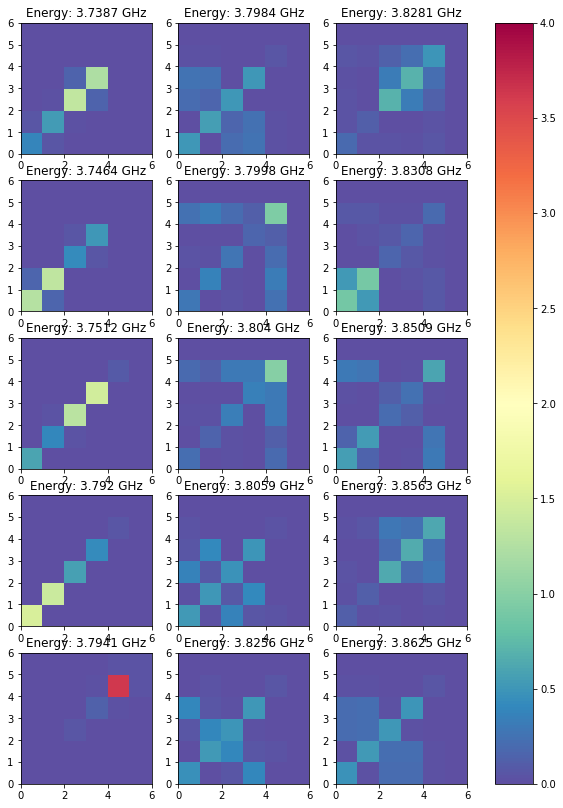

In [20]:
fig, axes = plt.subplots(5,3,figsize=(10,14))
im = axes[0,0].pcolormesh(n2[13,:,:], vmin=0, vmax=4, cmap='Spectral_r')
axes[0,0].set_title('Energy: {:4.5g} GHz'.format(f02h_simulations[5][6]/1e9))
axes[1,0].pcolormesh(n2[14,:,:], vmin=0, vmax=4, cmap='Spectral_r')
axes[1,0].set_title('Energy: {:4.5g} GHz'.format(f02h_simulations[5][7]/1e9))
axes[2,0].pcolormesh(n2[15,:,:], vmin=0, vmax=4, cmap='Spectral_r')
axes[2,0].set_title('Energy: {:4.5g} GHz'.format(f02h_simulations[5][8]/1e9))
axes[3,0].pcolormesh(n2[16,:,:], vmin=0, vmax=4, cmap='Spectral_r')
axes[3,0].set_title('Energy: {:4.5g} GHz'.format(f02h_simulations[5][9]/1e9))
axes[4,0].pcolormesh(n2[17,:,:], vmin=0, vmax=4, cmap='Spectral_r')
axes[4,0].set_title('Energy: {:4.5g} GHz'.format(f02h_simulations[5][10]/1e9))

axes[0,1].pcolormesh(n2[18,:,:], vmin=0, vmax=4, cmap='Spectral_r')
axes[0,1].set_title('Energy: {:4.5g} GHz'.format(f02h_simulations[5][11]/1e9))
axes[1,1].pcolormesh(n2[19,:,:], vmin=0, vmax=4, cmap='Spectral_r')
axes[1,1].set_title('Energy: {:4.5g} GHz'.format(f02h_simulations[5][12]/1e9))
axes[2,1].pcolormesh(n2[20,:,:], vmin=0, vmax=4, cmap='Spectral_r')
axes[2,1].set_title('Energy: {:4.5g} GHz'.format(f02h_simulations[5][13]/1e9))
axes[3,1].pcolormesh(n2[21,:,:], vmin=0, vmax=4, cmap='Spectral_r')
axes[3,1].set_title('Energy: {:4.5g} GHz'.format(f02h_simulations[5][14]/1e9))
axes[4,1].pcolormesh(n2[22,:,:], vmin=0, vmax=4, cmap='Spectral_r')
axes[4,1].set_title('Energy: {:4.5g} GHz'.format(f02h_simulations[5][15]/1e9))

axes[0,2].pcolormesh(n2[23,:,:], vmin=0, vmax=4, cmap='Spectral_r')
axes[0,2].set_title('Energy: {:4.5g} GHz'.format(f02h_simulations[5][16]/1e9))
axes[1,2].pcolormesh(n2[24,:,:], vmin=0, vmax=4, cmap='Spectral_r')
axes[1,2].set_title('Energy: {:4.5g} GHz'.format(f02h_simulations[5][17]/1e9))
axes[2,2].pcolormesh(n2[25,:,:], vmin=0, vmax=4, cmap='Spectral_r')
axes[2,2].set_title('Energy: {:4.5g} GHz'.format(f02h_simulations[5][18]/1e9))
axes[3,2].pcolormesh(n2[26,:,:], vmin=0, vmax=4, cmap='Spectral_r')
axes[3,2].set_title('Energy: {:4.5g} GHz'.format(f02h_simulations[5][19]/1e9))
axes[4,2].pcolormesh(n2[27,:,:], vmin=0, vmax=4, cmap='Spectral_r')
axes[4,2].set_title('Energy: {:4.5g} GHz'.format(f02h_simulations[5][20]/1e9))
plt.colorbar(im, ax=axes)
plt.savefig('2photon-states.svg')

In [8]:
cp = exdir_db_inst.select_measurement(measurement_type = 'linear_oscillator_model_parameters')
def meas_to_fn(m):
    m_ref = exdir_db_inst.select_measurement(measurement_type = 'resonator', references_this={'resonator':m.id})
    resonator_scan_f = m_ref.datasets['S-parameter'].parameters[1].values
    resonator_scan_S21 = np.mean(m_ref.datasets['S-parameter'].data, axis=0)
    f_extracted = m.datasets['S-parameter'].parameters[2].values[0]
    fitter = circuit.notch_port(resonator_scan_f, resonator_scan_S21)
    fitter.autofit(electric_delay=68e-9)
    fr = fitter.fitresults['fr']
    S21_func = interp1d(fitter.f_data, fitter.z_data_sim*np.exp(1j*resonator_scan_f*2*np.pi*68e-9), 
                        fill_value="extrapolate")

    S0 = S21_func(f_extracted)/np.exp(1j*fr*2*np.pi*68e-9)
    df = 100

    dSdf = (S21_func(fr+df*0.5)-S21_func(fr-df*0.5))/df/np.exp(1j*fr*2*np.pi*68e-9)
    chi = lambda S: least_squares(residuals, fr, args=(S,)).x-f_extracted

    x = m.datasets['S-parameter'].parameters[1].values
    y = m.datasets['S-parameter'].parameters[0].values
    z_cmplx = m.datasets['S-parameter'].data_squeezed

    z = np.real(np.mean(z_cmplx-S0, axis=0)/dSdf)
    #z = z-np.median(z)
    g = np.sqrt(cp.datasets['fr'].data[0])*float(cp.metadata['g'])
    delta = float(cp.metadata['EC'])
    fr = cp.datasets['fr'].data[0]
    fq = 3.8e9
    dispersive_shift = 2*g**2*delta/((fq-fr)*(fq-delta-fr))
    
    return x, z/dispersive_shift

In [144]:
cp = exdir_db_inst.select_measurement(measurement_type = 'linear_oscillator_model_parameters')
def old_meas_to_fn(m, fq=3.75e9, fq_resonator_scan=3.8e9):
    m_ref = exdir_db_inst.select_measurement(measurement_type = 'resonator', 
                                             metadata={'resonator_id':m.metadata['resonator_id']})
    resonator_scan_f = m_ref.datasets['S-parameter'].parameters[1].values
    resonator_scan_S21 = np.mean(m_ref.datasets['S-parameter'].data, axis=0)
    f_extracted = m.datasets['S-parameter'].parameters[2].values[0]
    fitter = circuit.notch_port(resonator_scan_f, resonator_scan_S21)
    fitter.autofit(electric_delay=68e-9)
    fr = fitter.fitresults['fr']
    S21_func = interp1d(fitter.f_data, fitter.z_data_sim*np.exp(1j*resonator_scan_f*2*np.pi*68e-9), 
                        fill_value="extrapolate")

    
    g = np.sqrt(cp.datasets['fr'].data[0])*float(cp.metadata['g'])
    delta = float(cp.metadata['EC'])
    fr_param = cp.datasets['fr'].data[0]
    
    delta_f = g**2/(fr-fq)**2*(fq-fq_resonator_scan)
    #print (delta_f)
    S0 = S21_func(f_extracted+delta_f)/np.exp(1j*(fr)*2*np.pi*68e-9)
    df = 100

    #print (S0)
    
    dSdf = (S21_func(fr+df*0.5)-S21_func(fr-df*0.5))/df/np.exp(1j*fr*2*np.pi*68e-9)
    #chi = lambda S: least_squares(residuals, fr, args=(S,)).x-f_extracted

    x = m.datasets['S-parameter'].parameters[1].values
    y = m.datasets['S-parameter'].parameters[0].values
    z_cmplx = m.datasets['S-parameter'].data_squeezed
    
    re_hist, re_bin_edges = np.histogram(np.real(z_cmplx), bins=np.prod(np.shape(z_cmplx)))
    im_hist, im_bin_edges = np.histogram(np.imag(z_cmplx), bins=np.prod(np.shape(z_cmplx)))
    
    #plt.plot((re_bin_edges[1:]+re_bin_edges[:-1])/2, re_hist)
    #plt.plot((im_bin_edges[1:]+im_bin_edges[:-1])/2, im_hist)
    S0 = ((re_bin_edges[1:]+re_bin_edges[:-1])/2)[np.argmax(re_hist)]+\
      1j*((im_bin_edges[1:]+im_bin_edges[:-1])/2)[np.argmax(im_hist)]
    
    z = np.real((z_cmplx-S0)/dSdf)
    #z = z-np.median(z)
    #fq = 3.8e9
    dispersive_shift = 2*g**2*delta/((fq-fr_param)*(fq-delta-fr_param))
    #print (dispersive_shift)
    
    return x, z/dispersive_shift

In [145]:
m = exdir_db_inst_old.select_measurement(measurement_type='two_tone_11q_power',
                                                     metadata={'resonator_id':'1',
                                                               'num_resonant_qubits':'2'})
x, z = old_meas_to_fn(m)

2 1 1 4921
2 11 10 4955
2 11 11 4935
3 1 1 4922
3 11 10 4956
3 11 11 4936
4 1 1 4923
4 11 10 4947
4 11 11 4937
5 1 1 4924
5 11 10 4948
5 11 11 4938
6 1 1 4925
6 11 10 4949
6 11 11 4939
7 1 1 4926
7 11 10 4950
7 11 11 4940
8 1 1 4927
8 11 10 4951
8 11 11 4941


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



9 1 1 4928
9 11 10 4952
9 11 11 4942
10 1 1 4929
10 11 10 4953
10 11 11 4943
11 1 1 4930
11 11 10 4954
11 11 11 4944


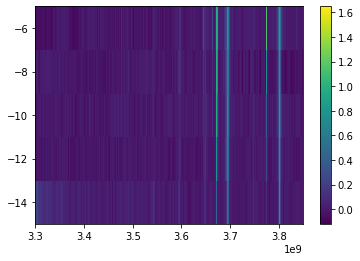

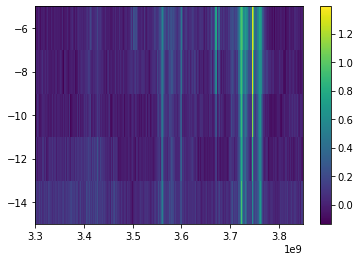

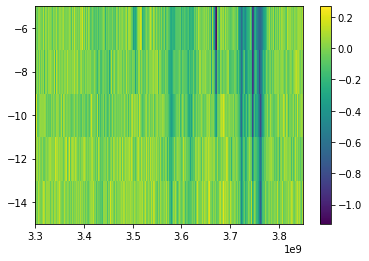

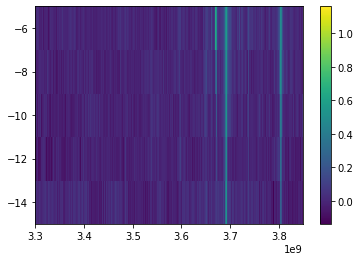

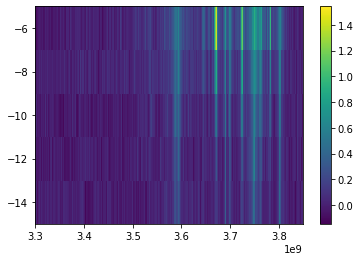

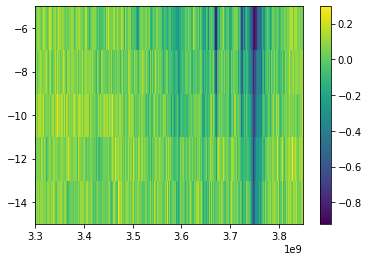

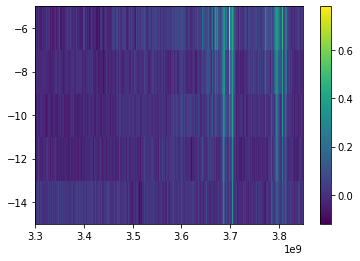

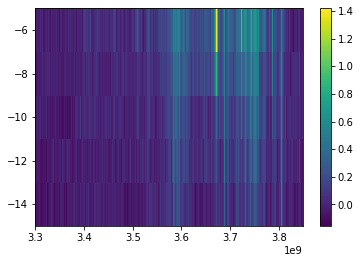

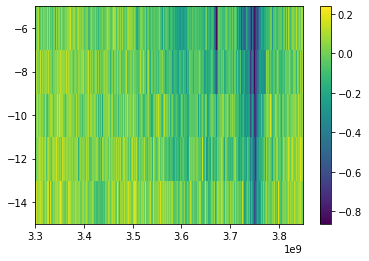

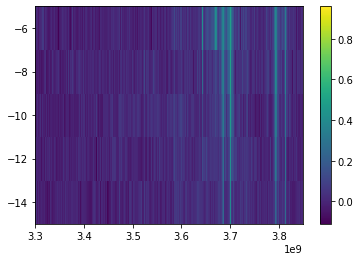

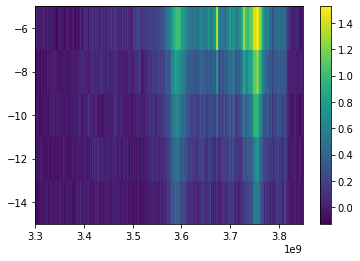

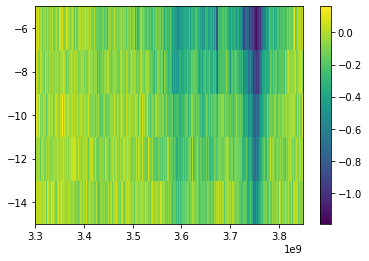

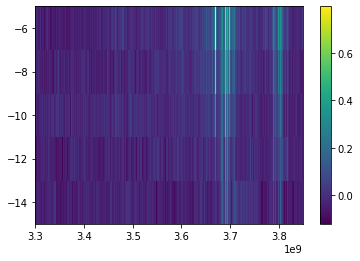

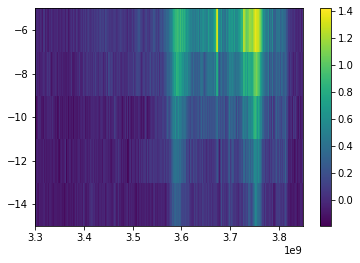

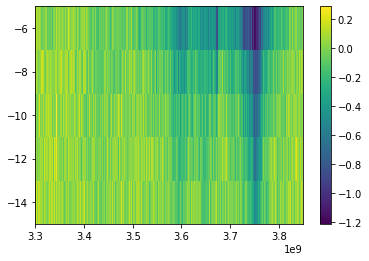

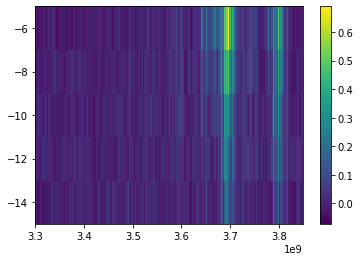

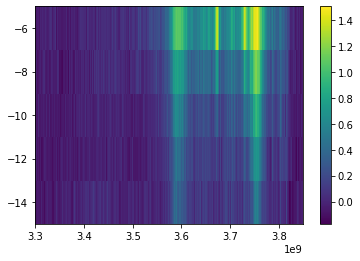

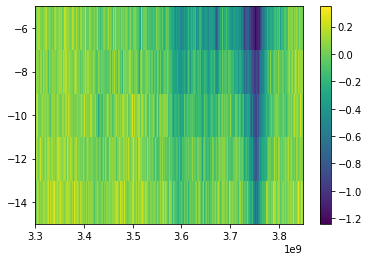

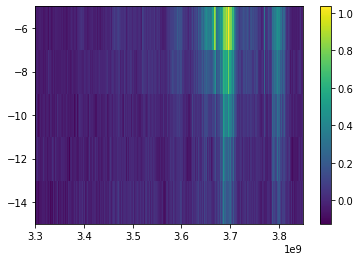

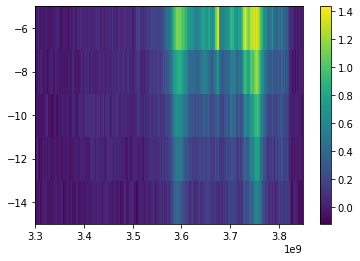

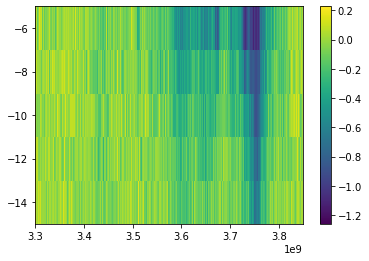

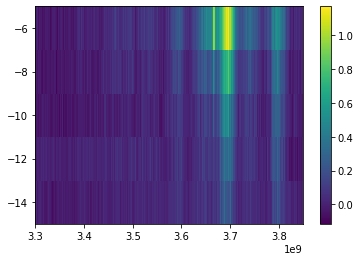

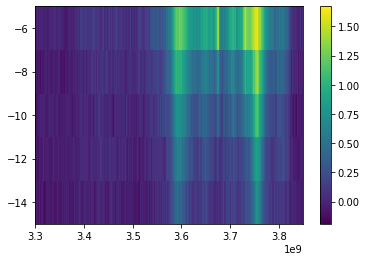

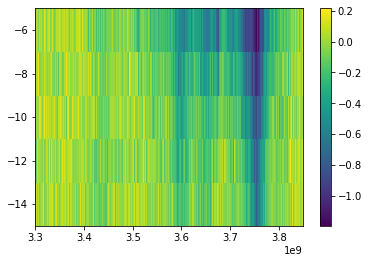

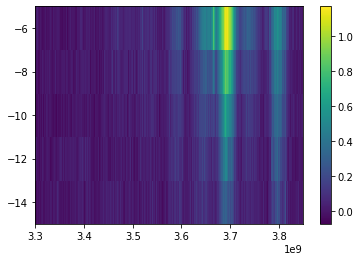

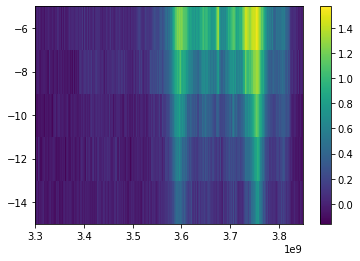

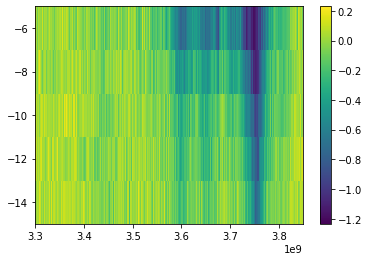

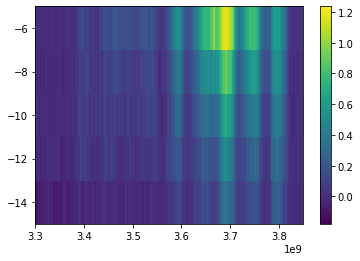

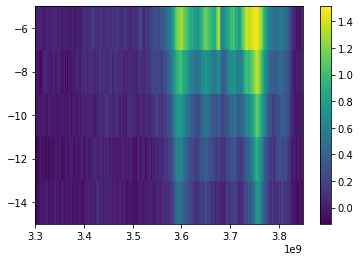

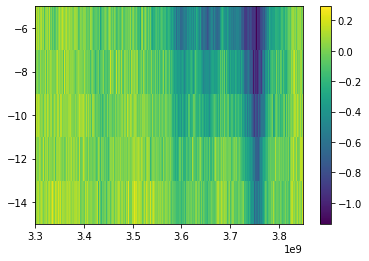

In [146]:
import pandas
for num_resonant_qubits in range(2,12):
    for resonator_id in ['1', '10', '11']:
        ex_qubit = resonator_id if resonator_id != '10' else '11'
        num_resonant_qubits_ = num_resonant_qubits if resonator_id == '1' else 12 - num_resonant_qubits
        m = exdir_db_inst_old.select_measurement(measurement_type='two_tone_11q_power',
                                                             metadata={'resonator_id':resonator_id,
                                                                       'num_resonant_qubits':str(num_resonant_qubits_)})
        x, z = old_meas_to_fn(m)
        #for power in measurement_power.datasets['S-parameter']
        for power_id, power in enumerate(m.datasets['S-parameter'].parameters[0].values):
            pandas.DataFrame({'f':x, '<n>':z[power_id, :]}).to_csv(r'D:\data\2020-03-31\spectra-ascii-3.75\spectrum_nq-{nq}_ro-{ro}_ex-{ex}_power-{power}.tsv'.format(
                    nq=num_resonant_qubits,
                    ex=ex_qubit,#m.metadata['ex_qubit'],
                    ro=resonator_id, 
                    power=power), sep='\t')
        print (num_resonant_qubits, ex_qubit, resonator_id, m.id)
        plt.figure()
        plt.pcolormesh(x,m.datasets['S-parameter'].parameters[0].values, z)
        plt.colorbar()

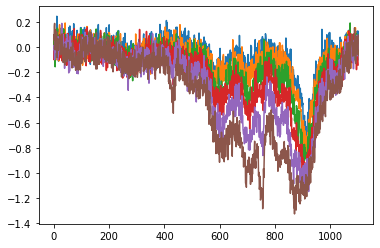

In [127]:
plt.plot(old_meas_to_fn(m)[1].T)
#plt.colorbar()

In [19]:
from resonator_tools import circuit
m_ref = exdir_db_inst.select_measurement(measurement_type = 'resonator', metadata={'resonator_id':'1'})
resonator_scan_f = m_ref.datasets['S-parameter'].parameters[1].values
resonator_scan_S21 = np.mean(m_ref.datasets['S-parameter'].data, axis=0)
f_extracted = m.datasets['S-parameter'].parameters[2].values[0]
fitter = circuit.notch_port(resonator_scan_f, resonator_scan_S21)
fitter.autofit(electric_delay=68e-9)
fr = fitter.fitresults['fr']
fq=3.8e9
fr, fr-fq, fr-fq+0.155e9

(6260443295.975374, 2460443295.975374, 2615443295.975374)

In [14]:
cp.metadata['EC']

'155000000.0'

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:17<00:00,  1.60s/it]


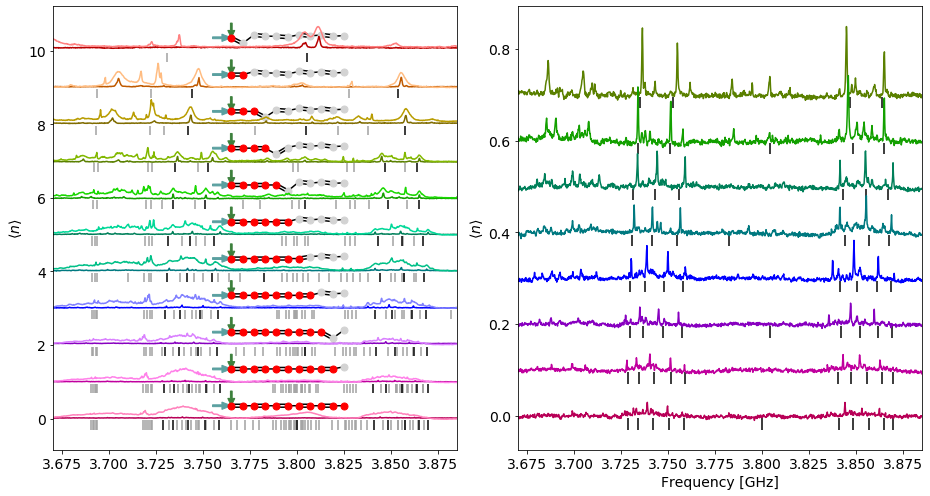

In [22]:
min_num_qubits = 1
max_num_qubits = 11
simulation_qubit_num = 11
zoom_qubit_id = 4
cp = exdir_db_inst.select_measurement(measurement_type = 'linear_oscillator_model_parameters')
#fig, axes = plt.subplots(max_num_qubits-min_num_qubits+1,2, figsize=(12, 14), sharex=True)
fig, axes = plt.subplots(1,2, figsize=(13, 7), sharex=True)#, gridspec_kw={'height_ratios': [2, 1]})
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=14)
#axes[0].set_xlabel('Frequency [GHz]', fontsize=14)
axes[1].set_xlabel('Frequency [GHz]', fontsize=14)
axes[0].set_ylabel(r'$\langle n \rangle$', fontsize=14)
axes[1].set_ylabel(r'$\langle n \rangle$', fontsize=14)
for num_qubits in tqdm(range(min_num_qubits, max_num_qubits+1)):
    coil_voltages = {}
    
    #qubit_x = np.linspace(3.675+0.01, 3.675+0.01+0.008*(num_qubits-1), num_qubits)
    qubit_x = np.linspace(3.755+0.01, 3.755+0.01+0.006*(max_num_qubits-1), max_num_qubits)
    #qubit_y = np.asarray(qubit_frequencies_raw[num_qubits-1][:num_qubits])/1e9-3.8+max_num_qubits-num_qubits+0.5
    qubit_y = (np.asarray(qubit_frequencies_raw[num_qubits-1][:max_num_qubits])/1e9-3.8)/3 + \
                max_num_qubits-num_qubits+0.35
    #print (len(qubit_y), len(qubit_x), num_qubits)
    for qubit_id in range(max_num_qubits):
        if not qubit_id % 2:
            axes[0].plot(qubit_x[qubit_id:(qubit_id+2)], 
                         qubit_y[qubit_id:(qubit_id+2)]+0.04,
                         color='black')
            axes[0].plot(qubit_x[qubit_id:(qubit_id+2)], 
                         qubit_y[qubit_id:(qubit_id+2)]-0.04, 
                         color='black')
        else:
            axes[0].plot(qubit_x[qubit_id:(qubit_id+2)], 
                         qubit_y[qubit_id:(qubit_id+2)],
                         color='black')
            
    axes[0].plot(qubit_x[:num_qubits], 
                 qubit_y[:num_qubits],
           marker='o', markersize=7, linestyle='', color='red')
    axes[0].plot(qubit_x[num_qubits:], 
                 qubit_y[num_qubits:],
           marker='o', markersize=7, linestyle='', color='lightgray')
    
    axes[0].arrow(qubit_x[0]-0.01, qubit_y[0], 0.01, 0, 
                  length_includes_head=True, head_width=0.2, 
                  head_length=0.005, width=0.05, color='#5aa0a0')
    axes[0].arrow(qubit_x[0], qubit_y[0]+0.4, 0, -0.4, 
                  length_includes_head=True, head_width=0.00375, 
                  head_length=0.2, width=0.0009375, color='#3c803c')
    
    for fig_id, power in enumerate(['-20.0', '0.0']):
        m=exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                                 metadata={'num_resonant_qubits': num_qubits,
                                                           'resonator_id':'1',
                                                           'ex_qubit': '1',
                                                           'pump_power': power})
        x, z = meas_to_fn(m)
        
        if fig_id == 0:
            ax = axes[0]
        elif fig_id == 1:
            ax = axes[0]

        ax.set_xlim(3.67, 3.885)

        if fig_id == 0:
            color = colors_dark[num_qubits-min_num_qubits]
        else:
            color = colors_light[num_qubits-min_num_qubits]
        
        #ax.set_ylabel('$\\langle n \\rangle$, {} power'.format('high' if fig_id else 'low'), color=color) 
        #mul = (fig_id+0.5)/1.5
        mul = 1
        ax.plot(x/1e9, z+(max_num_qubits-num_qubits)*mul, color=color)

        if num_qubits >= zoom_qubit_id and fig_id==0:
            mul = 0.1
            z = z - np.median(z)
            axes[1].plot(x/1e9, z+(max_num_qubits-num_qubits)*mul, color=color)
        #ax.tick_params(axis='y', labelcolor=color)
        
        num_qubits_in_mode = (num_qubits//2)*2
        num_qubits_in_mode = 1 if num_qubits_in_mode == 0 else num_qubits_in_mode
        #axes[num_qubits-min_num_qubits,0].set_ylim(-0.5/num_qubits_in_mode*0.3, 0.5/num_qubits_in_mode*1.6)
        #axes[num_qubits-min_num_qubits,1].set_ylim(-0.2, 0.7)    
            
        for coil, voltage in m.metadata.items():
            if coil[:6] == 'NNDAC-':
                if int(coil[6:]) in coil_qubits.keys():
                    coil_voltages[coil_qubits[int(coil[6:])]] = float(voltage)
        coil_voltages_vec = [coil_voltages[qubit_id] for qubit_id in coil_qubits.values()]

    f01 = f01_simulations[num_qubits-min_num_qubits]
    f02h = f02h_simulations[num_qubits-min_num_qubits]
    for fig_id, power in enumerate(['-20.0', '0.0']):
        #mul = (fig_id+1)/1.5
        mul = 1
        if fig_id == 0:
            axes[0].vlines(f02h/1e9, color='#a0a0a0', ymin=(max_num_qubits-num_qubits)*mul-0.3*mul, ymax=(max_num_qubits-num_qubits)*mul-0.05*mul)
            axes[0].vlines(f01/1e9, color='black', ymin=(max_num_qubits-num_qubits)*mul-0.3*mul, ymax=(max_num_qubits-num_qubits)*mul-0.05*mul)
            if num_qubits >= zoom_qubit_id:
                mul = 0.1
                axes[1].vlines(f01/1e9, color='black', ymin=(max_num_qubits-num_qubits)*mul-0.3*mul, ymax=(max_num_qubits-num_qubits)*mul-0.05*mul)
    

#        if fig_id == 1:
#            axes[2].vlines(f01, color='black', ymin=(max_num_qubits-num_qubits)*mul-0.3*mul, ymax=(max_num_qubits-num_qubits)*mul-0.15*mul)
    #for qubit_id in range(simulation_qubit_num):
    #    axes[num_qubits-min_num_qubits, 0].axvline(f01[qubit_id], color='purple', linestyle=':', linewidth=2)
    #    axes[num_qubits-min_num_qubits, 1].axvline(f01[qubit_id], color='purple', linestyle=':', linewidth=2)
    

    
plt.tight_layout()
plt.savefig('two_tone_11q_power_1q_readout_1q_signal')
plt.savefig('two_tone_11q_power_1q_readout_1q_signal.pdf')

plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.31it/s]


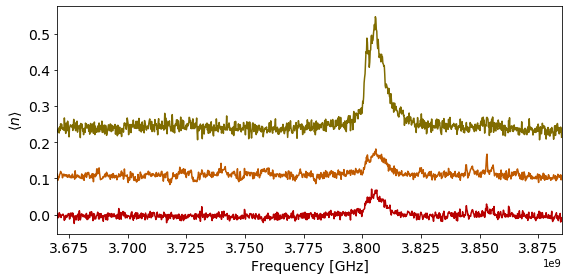

In [23]:
min_num_qubits = 9
max_num_qubits = 11
simulation_qubit_num = 11
cp = exdir_db_inst.select_measurement(measurement_type = 'linear_oscillator_model_parameters')

fig, axes = plt.subplots(1,1, figsize=(8, 4), sharex=True)
axes.tick_params(axis='both', which='major', labelsize=14)
axes.set_xlabel('Frequency [GHz]', fontsize=14)
axes.set_ylabel(r'$\langle n \rangle$', fontsize=14)

for num_qubits in tqdm(range(min_num_qubits, max_num_qubits+1)):
    coil_voltages = {}
    for fig_id, power in enumerate(['-10.0']):
        m=exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                                 metadata={'num_resonant_qubits': '11',
                                                           'resonator_id':num_qubits,
                                                           'ex_qubit': '11',
                                                           'pump_power': power})
        x, z = meas_to_fn(m)
        
        ax = axes
        ax.set_xlim(3.67e9, 3.885e9)

        if fig_id == 0:
            color = colors_dark[num_qubits-min_num_qubits]
        else:
            color = colors_light[num_qubits-min_num_qubits]
        
        mul = 0.1
        ax.plot(x, z+mul*(-min_num_qubits+num_qubits), color=color)#np.mean(z, axis=0))

plt.tight_layout()
plt.savefig('two_tone_11q_power_11q_readout_1q_signal')
plt.savefig('two_tone_11q_power_11q_readout_1q_signal.pdf')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.36it/s]


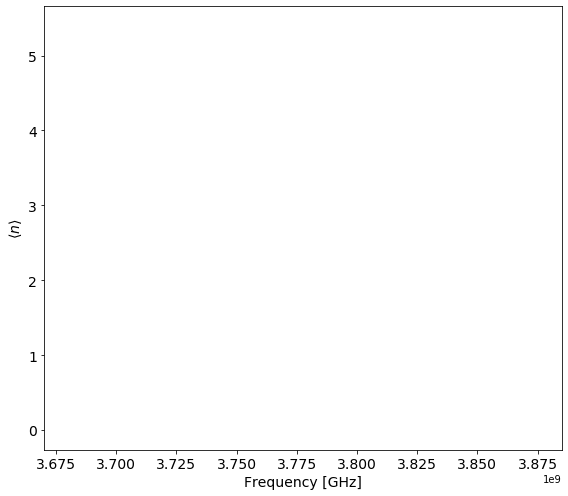

In [24]:
min_num_qubits = 1
max_num_qubits = 11
simulation_qubit_num = 11
cp = exdir_db_inst.select_measurement(measurement_type = 'linear_oscillator_model_parameters')

fig, axes = plt.subplots(1,1, figsize=(8, 7), sharex=True)
axes.tick_params(axis='both', which='major', labelsize=14)
axes.set_xlabel('Frequency [GHz]', fontsize=14)
axes.set_ylabel(r'$\langle n \rangle$', fontsize=14)

for num_qubits in tqdm(range(min_num_qubits, max_num_qubits+1)):
    coil_voltages = {}
    for fig_id, power in enumerate(['-10.0']):
        m=exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                                 metadata={'num_resonant_qubits': num_qubits,
                                                           'resonator_id':'11',
                                                           'ex_qubit': '11',
                                                           'pump_power': power})
        x, z = meas_to_fn(m)
        
        ax = axes
        ax.set_xlim(3.67e9, 3.885e9)

        if fig_id == 0:
            color = colors_dark[num_qubits-min_num_qubits]
        else:
            color = colors_light[num_qubits-min_num_qubits]
         
        mul = 0.5
        ax.plot(x/1e9, z+mul*(+max_num_qubits-num_qubits), color=color)#np.mean(z, axis=0))     

plt.tight_layout()
plt.savefig('two_tone_nq_power_11q_readout_1q_signal')
plt.savefig('two_tone_nq_power_11q_readout_1q_signal.pdf')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.41it/s]


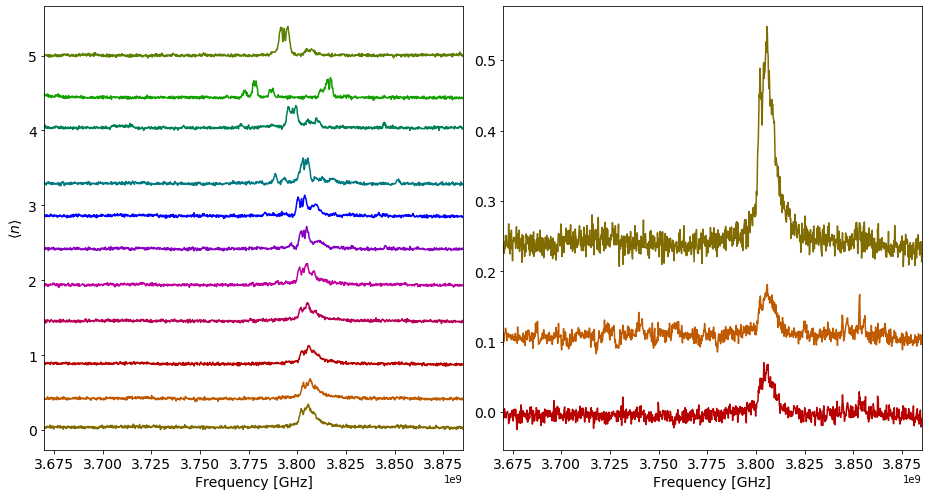

In [25]:
min_num_qubits = 9
max_num_qubits = 11
simulation_qubit_num = 11
cp = exdir_db_inst.select_measurement(measurement_type = 'linear_oscillator_model_parameters')

fig, axes = plt.subplots(1,2, figsize=(13, 7), sharex=True, sharey=False)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_xlabel('Frequency [GHz]', fontsize=14)
axes[1].set_xlabel('Frequency [GHz]', fontsize=14)
axes[0].set_ylabel(r'$\langle n \rangle$', fontsize=14)

for num_qubits in tqdm(range(1, max_num_qubits+1)):
    coil_voltages = {}
    for fig_id, power in enumerate(['-10.0']):
        m=exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                                 metadata={'num_resonant_qubits': num_qubits,
                                                           'resonator_id':'11',
                                                           'ex_qubit': '11',
                                                           'pump_power': power})
        x, z = meas_to_fn(m)
        
        ax = axes[0]
        ax.set_xlim(3.67e9, 3.885e9)

        if fig_id == 0:
            color = colors_dark[num_qubits-min_num_qubits]
        else:
            color = colors_light[num_qubits-min_num_qubits]
         
        mul = 0.5
        ax.plot(x, z+mul*(+max_num_qubits-num_qubits), color=color)#np.mean(z, axis=0))     

for num_qubits in tqdm(range(min_num_qubits, max_num_qubits+1)):
    coil_voltages = {}
    for fig_id, power in enumerate(['-10.0']):
        m=exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                                 metadata={'num_resonant_qubits': '11',
                                                           'resonator_id':num_qubits,
                                                           'ex_qubit': '11',
                                                           'pump_power': power})
        x, z = meas_to_fn(m)
        
        ax = axes[1]
        ax.set_xlim(3.67e9, 3.885e9)

        if fig_id == 0:
            color = colors_dark[num_qubits-min_num_qubits]
        else:
            color = colors_light[num_qubits-min_num_qubits]
        
        mul = 0.1
        ax.plot(x, z+mul*(-min_num_qubits+num_qubits), color=color)#np.mean(z, axis=0))

plt.tight_layout()
plt.savefig('two_tone_11q_power_11q_readout_1q_signal')
plt.savefig('two_tone_11q_power_11q_readout_1q_signal.pdf')
plt.show()

# Edge state + bands together

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:25<00:00,  2.35s/it]


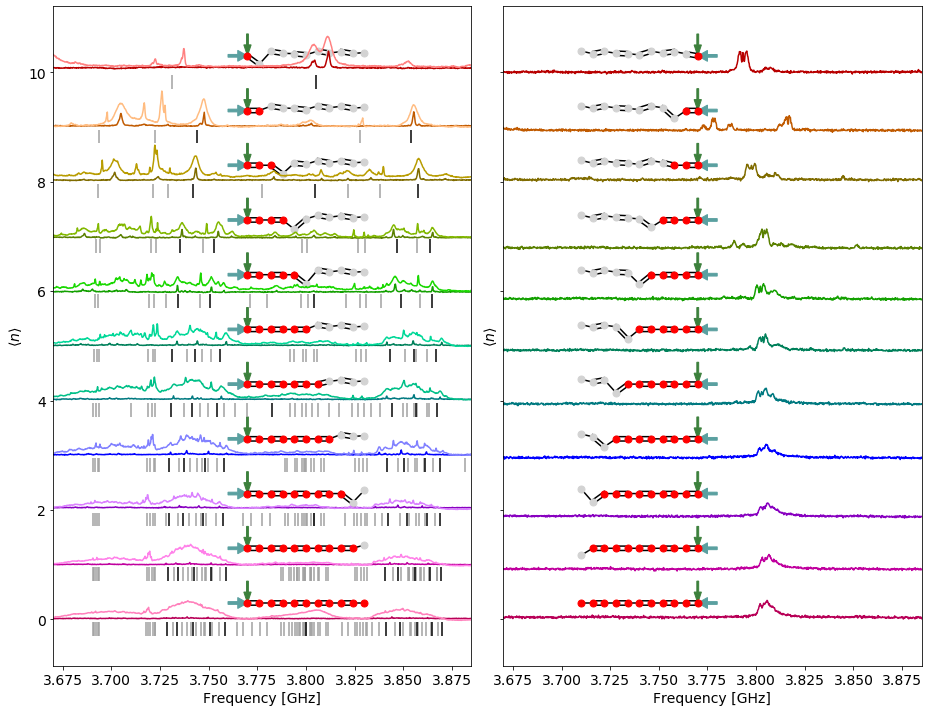

In [139]:
min_num_qubits = 1
max_num_qubits = 11
simulation_qubit_num = 11
zoom_qubit_id = 4
cp = exdir_db_inst.select_measurement(measurement_type = 'linear_oscillator_model_parameters')
#fig, axes = plt.subplots(max_num_qubits-min_num_qubits+1,2, figsize=(12, 14), sharex=True)
fig, axes = plt.subplots(1,2, figsize=(13, 10), sharex=True, sharey=True)#, gridspec_kw={'height_ratios': [2, 1]})
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_xlabel('Frequency [GHz]', fontsize=14)
axes[1].set_xlabel('Frequency [GHz]', fontsize=14)
axes[0].set_ylabel(r'$\langle n \rangle$', fontsize=14)
axes[1].set_ylabel(r'$\langle n \rangle$', fontsize=14)
for num_qubits in tqdm(range(min_num_qubits, max_num_qubits+1)):
    coil_voltages = {}
    
    #qubit_x = np.linspace(3.675+0.01, 3.675+0.01+0.008*(num_qubits-1), num_qubits)
    muls = [1, -1]
    qubit_x = [np.linspace(3.755+0.015, 3.755+0.015+0.006*muls[0]*(max_num_qubits-1), max_num_qubits),
               np.linspace(3.755+0.015, 3.755+0.015+0.006*muls[1]*(max_num_qubits-1), max_num_qubits)]
    #qubit_y = np.asarray(qubit_frequencies_raw[num_qubits-1][:num_qubits])/1e9-3.8+max_num_qubits-num_qubits+0.5
    qubit_y = [ (np.asarray(qubit_frequencies_raw[num_qubits-1][:max_num_qubits])/1e9-3.8)/3 + \
                max_num_qubits-num_qubits+0.3,
                (np.asarray(edge_qubit_frequencies_raw[num_qubits-1][:max_num_qubits][::-1])/1e9-3.8)/3 + \
                max_num_qubits-num_qubits+0.3 ]
    #print (len(qubit_y), len(qubit_x), num_qubits)
    for axis_id in range(2):
        for qubit_id in range(max_num_qubits):
            if not qubit_id % 2:
                axes[axis_id].plot(qubit_x[axis_id][qubit_id:(qubit_id+2)], 
                                   qubit_y[axis_id][qubit_id:(qubit_id+2)]+0.04,
                                   color='black')
                axes[axis_id].plot(qubit_x[axis_id][qubit_id:(qubit_id+2)], 
                                   qubit_y[axis_id][qubit_id:(qubit_id+2)]-0.04, 
                                   color='black')
    
            else:
                axes[axis_id].plot(qubit_x[axis_id][qubit_id:(qubit_id+2)], 
                                   qubit_y[axis_id][qubit_id:(qubit_id+2)],
                                   color='black')
            
        axes[axis_id].plot(qubit_x[axis_id][:num_qubits], qubit_y[axis_id][:num_qubits],
               marker='o', markersize=7, linestyle='', color='red')
        axes[axis_id].plot(qubit_x[axis_id][num_qubits:], qubit_y[axis_id][num_qubits:],
               marker='o', markersize=7, linestyle='', color='lightgray')
    
        axes[axis_id].arrow(qubit_x[axis_id][0]-0.01*muls[axis_id], qubit_y[axis_id][0], 0.01*muls[axis_id], 0, 
                      length_includes_head=True, head_width=0.2, 
                      head_length=0.005, width=0.05, color='#5aa0a0')
        axes[axis_id].arrow(qubit_x[axis_id][0], qubit_y[axis_id][0]+0.4, 0, -0.4, 
                      length_includes_head=True, head_width=0.00375, 
                      head_length=0.2, width=0.0009375, color='#3c803c')
    
    
    
    for fig_id, power in enumerate(['-20.0', '0.0']):
        m=exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                                 metadata={'num_resonant_qubits': num_qubits,
                                                           'resonator_id':'1',
                                                           'ex_qubit': '1',
                                                           'pump_power': power})
        x, z = meas_to_fn(m)
        
        pandas.DataFrame({'f':x, '<n>':z}).to_csv('spectrum_nq-{nq}_ro-{ro}_ex-{ex}_power-{power}.tsv'.format(
            nq=m.metadata['num_resonant_qubits'],
            ex=m.metadata['ex_qubit'],
            ro=m.metadata['resonator_id'], 
            power=m.metadata['pump_power']), sep='\t')
        
        if fig_id == 0:
            ax = axes[0]
        elif fig_id == 1:
            ax = axes[0]

        ax.set_xlim(3.67, 3.885)

        if fig_id == 0:
            color = colors_dark[num_qubits-min_num_qubits]
        else:
            color = colors_light[num_qubits-min_num_qubits]
            
        mul = 1
        ax.plot(x/1e9, z+(max_num_qubits-num_qubits)*mul, color=color)
        
        num_qubits_in_mode = (num_qubits//2)*2
        num_qubits_in_mode = 1 if num_qubits_in_mode == 0 else num_qubits_in_mode
        #axes[num_qubits-min_num_qubits,0].set_ylim(-0.5/num_qubits_in_mode*0.3, 0.5/num_qubits_in_mode*1.6)
        #axes[num_qubits-min_num_qubits,1].set_ylim(-0.2, 0.7)    
            
        for coil, voltage in m.metadata.items():
            if coil[:6] == 'NNDAC-':
                if int(coil[6:]) in coil_qubits.keys():
                    coil_voltages[coil_qubits[int(coil[6:])]] = float(voltage)
        coil_voltages_vec = [coil_voltages[qubit_id] for qubit_id in coil_qubits.values()]
        
    f01 = f01_simulations[num_qubits-min_num_qubits]
    f02h = f02h_simulations[num_qubits-min_num_qubits]
    for fig_id, power in enumerate(['-20.0', '0.0']):
        #mul = (fig_id+1)/1.5
        mul = 1
        if fig_id == 0:
            axes[0].vlines(f02h/1e9, color='#a0a0a0', ymin=(max_num_qubits-num_qubits)*mul-0.3*mul, ymax=(max_num_qubits-num_qubits)*mul-0.05*mul)
            axes[0].vlines(f01/1e9, color='black', ymin=(max_num_qubits-num_qubits)*mul-0.3*mul, ymax=(max_num_qubits-num_qubits)*mul-0.05*mul)
    
    coil_voltages = {}
    
    for fig_id, power in enumerate(['-10.0']):
        m=exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                                 metadata={'num_resonant_qubits': num_qubits,
                                                           'resonator_id':'11',
                                                           'ex_qubit': '11',
                                                           'pump_power': power})
        x, z = meas_to_fn(m)

        ax = axes[1]
        ax.set_xlim(3.67, 3.885)

        if fig_id == 0:
            color = colors_dark[num_qubits-min_num_qubits]
        else:
            color = colors_light[num_qubits-min_num_qubits]

        mul = 1
        ax.plot(x/1e9, z+mul*(+max_num_qubits-num_qubits), color=color)#np.mean(z, axis=0)) 
        pandas.DataFrame({'f':x, '<n>':z}).to_csv('spectrum_nq-{nq}_ro-{ro}_ex-{ex}_power-{power}.tsv'.format(
            nq=m.metadata['num_resonant_qubits'],
            ex=m.metadata['ex_qubit'],
            ro=m.metadata['resonator_id'], 
            power=m.metadata['pump_power']), sep='\t')
    
plt.tight_layout()
plt.savefig('two_tone_11q_power_1q_readout_1q_signal')
plt.savefig('two_tone_11q_power_1q_readout_1q_signal.pdf')
plt.savefig('two_tone_11q_power_1q_readout_1q_signal.svg')

plt.show()

# Fitting linewidths

resonator_id: 9 power: -10.0 [3.80558345 0.06171291 0.02082187 0.00391179]
resonator_id: 10 power: -10.0 [3.80600804 0.06157494 0.02603702 0.00398956]
resonator_id: 11 power: -10.0 [3.80548545 0.27863421 0.03184426 0.00397844]
resonator_id: 9 power: -15.0 [3.80502419 0.03073714 0.01863158 0.00402907]
resonator_id: 10 power: -15.0 [3.80556339 0.02793749 0.01846238 0.00390932]
resonator_id: 11 power: -15.0 [3.80520995e+00 1.39383469e-01 3.28755870e-02 3.35162348e-03]


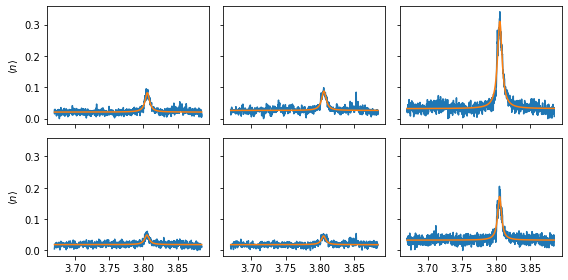

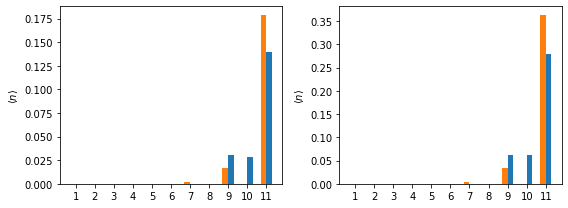

In [12]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas
from resonator_tools import circuit

curve_parameters = []
fig, axes = plt.subplots(2,3, figsize=(8,4), sharex=True, sharey=True)
z_all = []

for power_id, power in enumerate(['-10.0', '-15.0']):
    z_cumulative = 0
    for resonator_id_, resonator_id in enumerate(['9', '10', '11']):
        try:
            m=exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                                   metadata={'num_resonant_qubits': '11',
                                                             'resonator_id':resonator_id,
                                                             'ex_qubit': '11',
                                                             'pump_power': power})
        except IndexError as e:
            continue
            
        x, z = meas_to_fn(m)
        #
        pandas.DataFrame({'f':x, '<n>':z}).to_csv('spectrum_nq-{nq}_ro-{ro}_ex-{ex}_power-{power}.tsv'.format(
            nq=m.metadata['num_resonant_qubits'],
            ex=m.metadata['ex_qubit'],
            ro=m.metadata['resonator_id'], 
            power=m.metadata['pump_power']), sep='\t')
        
        z -= np.min(z)
        z_cumulative += z

        axes[power_id, resonator_id_].plot(x/1e9,z)

        def lorentzian( x, x0, a, b, gam ):
            return a* gam**2 / ( gam**2 + ( x - x0 )**2)+b

        fitresults = curve_fit(lorentzian, x/1e9, z, p0=(3.805, 0.2, 0.05, 0.001))[0]
        #print(fitresults)

        curve_parameters.append({'P':power, 
                                 'f0':fitresults[0], 
                                 'a':fitresults[1], 
                                 'b':fitresults[2],
                                 'df':fitresults[3], 
                                 'resonator_id':int(resonator_id),
                                 'power':int(float(power))})
        axes[power_id, resonator_id_].plot(x/1e9, lorentzian(x/1e9, *fitresults))
        if resonator_id_ == 0:
            axes[power_id, resonator_id_].set_ylabel('$\\langle n \\rangle$')
        z_all.append(z)
        print ('resonator_id:', resonator_id, 'power:', power, fitresults)
curve_parameters_pd = pandas.DataFrame(curve_parameters)
plt.tight_layout()
plt.savefig('resonances_edge_spatial.svg')
plt.savefig('resonances_edge_spatial.pdf')
plt.savefig('resonances_edge_spatial.png')
fig, axes = plt.subplots(1, 2, figsize=(8,3))
resonators_x = np.linspace(1, 11, 11)
resonators_y = (J1/J2)**resonators_x*0.5*(1-(-1)**resonators_x)
for id_, scan in enumerate(curve_parameters_pd.groupby('power')): 
    power, data = scan
    #print ('marker')
    #print (data['resonator_id'], data['a'])
    a = np.sum(data['a'])/np.sum(resonators_y)
    axes[id_].bar(np.asarray(data['resonator_id'])+0.15, np.asarray(data['a']), width=0.3)
    axes[id_].bar(resonators_x-0.15, resonators_y*a, width=0.3)
    axes[id_].set_xticks([1,2,3,4,5,6,7,8,9,10,11])
    axes[id_].set_ylabel('$\\langle n \\rangle$')
plt.tight_layout()
plt.savefig('edge_spatial.svg')
plt.savefig('edge_spatial.pdf')
plt.savefig('edge_spatial.png')

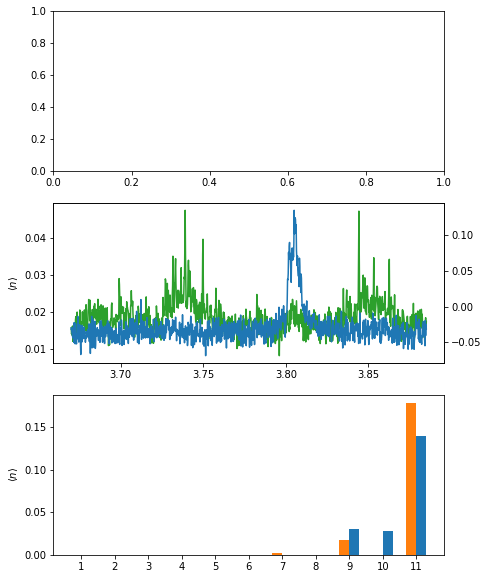

In [137]:
fig, axes = plt.subplots(3,1, figsize=(7,10))



for id_, scan in enumerate(curve_parameters_pd.groupby('power')): 
    if id_>0: 
        break
    power, data = scan

    a = np.sum(data['a'])/np.sum(resonators_y)
    axes[2].bar(np.asarray(data['resonator_id'])+0.15, np.asarray(data['a']), width=0.3)
    axes[2].bar(resonators_x-0.15, resonators_y*a, width=0.3)
    axes[2].set_xticks([1,2,3,4,5,6,7,8,9,10,11])
    axes[2].set_ylabel('$\\langle n \\rangle$')
    
m=exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                                 metadata={'num_resonant_qubits': 11,
                                                           'resonator_id':'1',
                                                           'ex_qubit': '1',
                                                           'pump_power': '-20.0'})
x, z = meas_to_fn(m)

axes[1].plot(x/1e9, z, color='C2')

m=exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                                   metadata={'num_resonant_qubits': '11',
                                                             'resonator_id':11,
                                                             'ex_qubit': '11',
                                                             'pump_power': '-15.0'})
ax2 = axes[1].twinx()
x, z = meas_to_fn(m)
ax2.plot(x/1e9, z)
p = [curve_parameters[5][key] for key in ['f0', 'a', 'b', 'df']]
#axes[1].plot(x/1e9, lorentzian(x/1e9, *p))
axes[1].set_ylabel('$\\langle n \\rangle$')
plt.savefig('low_power_11_qubits_compare.svg')
plt.savefig('low_power_11_qubits_compare.pdf')
plt.savefig('low_power_11_qubits_compare.png')
curve_parameters_pd.to_csv('resonances_edge_spatial.fit', sep='\t')


In [110]:
curve_parameters_pd

,P,a,b,df,f0,power,resonator_id
0,-10.0,0.061713,0.020822,0.003912,3.805583,-10,9
1,-10.0,0.061575,0.026037,0.003990,3.806008,-10,10
2,-10.0,0.278634,0.031844,0.003978,3.805485,-10,11
3,-15.0,0.030737,0.018632,0.004029,3.805024,-15,9
4,-15.0,0.027937,0.018462,0.003909,3.805563,-15,10
5,-15.0,0.139383,0.032876,0.003352,3.805210,-15,11


In [83]:
(curve_parameters['a'][0]*curve_parameters['df'][0]**2)/(curve_parameters['a'][1]*curve_parameters['df'][1]**2)

0.6409566508385156

In [89]:
10**(0.5)

3.1622776601683795

In [ ]:
from tqdm import tqdm
min_num_qubits = 7
max_num_qubits = 8
simulation_qubit_num = 8
fig, axes = plt.subplots(max_num_qubits-min_num_qubits+1,1, figsize=(8, 8), sharex=True)
for num_qubits in tqdm(range(min_num_qubits, max_num_qubits+1)):
    try:
        m = exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                             metadata={'num_resonant_qubits':num_qubits,
                                                       'resonator_id':'1'})
    except:
        raise
    
    coil_voltages = {}
    for coil, voltage in m.metadata.items():
        if coil[:6] == 'NNDAC-':
            if int(coil[6:]) in coil_qubits.keys():
                coil_voltages[coil_qubits[int(coil[6:])]] = float(voltage)
    coil_voltages_vec = [coil_voltages[qubit_id] for qubit_id in coil_qubits.values()]
    
    qubit_frequencies = []
    for qubit_id_, qubit_id in enumerate(coil_qubits.values()):
        qubit_flux = (inductance_matrix@coil_voltages_vec)[qubit_id_]+params['phi0'][qubit_id]
        qubit_frequencies.append(fqbare(params['EJ1'][qubit_id], params['EJ2'][qubit_id], params['EC'], qubit_flux))
    
    #print(qubit_frequencies)
    
    #print (coil_voltages)
    simulation_qubit_num = num_qubits
    vals, vecs_ = simulate_non_driven_frequencies(simulation_qubit_num, qubit_frequencies, J1, J2)
    f01 = vals[1:simulation_qubit_num+1]-vals[0]
    f02h = np.asarray(vals[simulation_qubit_num+1:]-vals[0])/2
#     print (vals)
    # thresholding by qubit 1 popluation
    #print ('Single-photon transitions:', f01)
    #print ('Two-photon transitions:', f02h)
    try:
        #m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power', metadata={'num_resonant_qubits':num_qubits})
        x = m.datasets['S-parameter'].parameters[1].values
        y = m.datasets['S-parameter'].parameters[0].values
        #z = np.abs(m.datasets['S-parameter'].data_squeezed)
        z_cmplx = m.datasets['S-parameter'].data_squeezed
        med = np.median(np.real(z_cmplx))+1j*np.median(np.imag(z_cmplx))
        z_nomed = z_cmplx-med
        
        r = np.real(z_nomed.ravel())
        i = np.imag(z_nomed.ravel())
        
        m = np.asarray([[np.mean(r*r), np.mean(r*i)],[np.mean(r*i), np.mean(i*i)]])
        vals, vecs = np.linalg.eigh(m)
        best_index = np.argmax(vals)
        component = vecs[best_index,:]
        
        z = np.real(z_nomed*np.conj(component[0]+1j*component[1]))
        z = z/np.max(z)
        
        #im = axes[num_qubits-min_num_qubits].pcolormesh(x,y,z, cmap='Spectral_r')
        axes[num_qubits-min_num_qubits].plot(x, np.nanmean(z, axis=0))
        axes[num_qubits-min_num_qubits].set_xlim(3.67e9, 3.885e9)
        #plt.colorbar(im, ax=axes[num_qubits-min_num_qubits])
        #axes[num_qubits-min_num_qubits].scatter(np.real(z), np.imag(z))
        for qubit_id in range(simulation_qubit_num):
            axes[num_qubits-min_num_qubits].axvline(f01[qubit_id], color='purple', linestyle=':', linewidth=3)
            
        #for transition_id in range((simulation_qubit_num*(simulation_qubit_num+1)//2)):
        #    axes[num_qubits-min_num_qubits].axvline(f02h[transition_id], color='red', linestyle=':', linewidth=3)
        
        #if num_qubits % 2:
        #    probabilities = np.abs(vecs_[(num_qubits+1)//2])**2
        #    populations = []
        #    for qubit_id in range(num_qubits):
                
        #    populations.append(np.reshape(probabilities, probabilities.dims[0])[
        #    ,...])
        #    probabilities = 
        #    axes[num_qubits-min_num_qubits,1].bar()
        
    except:
        raise
# plt.savefig('two_tone_11q_power_1q_readout_1q_signal')
plt.show()

In [14]:
from tqdm import tqdm
num_qubits = 6
m = exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                             metadata={'num_resonant_qubits':,
                                                       'resonator_id':'1'})

coil_voltages = {}
for coil, voltage in m.metadata.items():
    if coil[:6] == 'NNDAC-':
        if int(coil[6:]) in coil_qubits.keys():
            coil_voltages[coil_qubits[int(coil[6:])]] = float(voltage)
coil_voltages_vec = [coil_voltages[qubit_id] for qubit_id in coil_qubits.values()]
    
    qubit_frequencies = []
    for qubit_id_, qubit_id in enumerate(coil_qubits.values()):
        qubit_flux = (inductance_matrix@coil_voltages_vec)[qubit_id_]+params['phi0'][qubit_id]
        qubit_frequencies.append(fqbare(params['EJ1'][qubit_id], params['EJ2'][qubit_id], params['EC'], qubit_flux))
    
    #print(qubit_frequencies)
    
    #print (coil_voltages)
    simulation_qubit_num = num_qubits
    vals, vecs_ = simulate_non_driven_frequencies(simulation_qubit_num, qubit_frequencies, J1, J2)
    f01 = vals[1:simulation_qubit_num+1]-vals[0]
    f02h = np.asarray(vals[simulation_qubit_num+1:]-vals[0])/2
#     print (vals)
    # thresholding by qubit 1 popluation
    #print ('Single-photon transitions:', f01)
    #print ('Two-photon transitions:', f02h)
    try:
        #m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power', metadata={'num_resonant_qubits':num_qubits})
        x = m.datasets['S-parameter'].parameters[1].values
        y = m.datasets['S-parameter'].parameters[0].values
        #z = np.abs(m.datasets['S-parameter'].data_squeezed)
        z_cmplx = m.datasets['S-parameter'].data_squeezed
        med = np.median(np.real(z_cmplx))+1j*np.median(np.imag(z_cmplx))
        z_nomed = z_cmplx-med
        
        r = np.real(z_nomed.ravel())
        i = np.imag(z_nomed.ravel())
        
        m = np.asarray([[np.mean(r*r), np.mean(r*i)],[np.mean(r*i), np.mean(i*i)]])
        vals, vecs = np.linalg.eigh(m)
        best_index = np.argmax(vals)
        component = vecs[best_index,:]
        
        z = np.real(z_nomed*np.conj(component[0]+1j*component[1]))
        z = z/np.max(z)
        
        #im = axes[num_qubits-min_num_qubits].pcolormesh(x,y,z, cmap='Spectral_r')
        axes[num_qubits-min_num_qubits].plot(x, np.nanmean(z, axis=0))
        axes[num_qubits-min_num_qubits].set_xlim(3.67e9, 3.885e9)
        #plt.colorbar(im, ax=axes[num_qubits-min_num_qubits])
        #axes[num_qubits-min_num_qubits].scatter(np.real(z), np.imag(z))
        for qubit_id in range(simulation_qubit_num):
            axes[num_qubits-min_num_qubits].axvline(f01[qubit_id], color='purple', linestyle=':', linewidth=3)
            
        #for transition_id in range((simulation_qubit_num*(simulation_qubit_num+1)//2)):
        #    axes[num_qubits-min_num_qubits].axvline(f02h[transition_id], color='red', linestyle=':', linewidth=3)
        
        #if num_qubits % 2:
        #    probabilities = np.abs(vecs_[(num_qubits+1)//2])**2
        #    populations = []
        #    for qubit_id in range(num_qubits):
                
        #    populations.append(np.reshape(probabilities, probabilities.dims[0])[
        #    ,...])
        #    probabilities = 
        #    axes[num_qubits-min_num_qubits,1].bar()
        
    except:
        raise
# plt.savefig('two_tone_11q_power_1q_readout_1q_signal')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]


In [23]:
exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                             metadata={'num_resonant_qubits':num_qubits,
                                                       'resonator_id':'1'}).id

5296

In [11]:
axes[num_qubits-min_num_qubits].axvline

<bound method Axes.axvline of <matplotlib.axes._subplots.AxesSubplot object at 0x0000017FD8522F60>>

In [12]:
vecs_[(num_qubits+1)//2].dims[0]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [35]:
from tqdm import tqdm
curve_fit?

In [67]:
from scipy.optimize import curve_fit
m = exdir_db_inst.select_measurement_by_id(5397)
x = m.datasets['S-parameter'].parameters[0].values
y = m.datasets['S-parameter'].data
p0=(3.5400, 1.3e-4, -0.01, -0.01)
def fitfunc (x,f0,df,A,B): 
    #print (f0, df, A, B)
    #print (A-np.real((1j+1)*B/(x-f0+1j*df)))
    return A+np.real(1j*B*df/(x-f0+1j*df))
fitresults = curve_fit(fitfunc, x/1e9, np.real(y).ravel(), p0=p0, maxfev=10000)
plt.plot(x/1e9,np.real(y), marker='o', linestyle='')
y_fit = fitfunc(x/1e9, *fitresults[0])
plt.plot(x/1e9, y_fit, linewidth=4)
plt.savefig(r'C:\tupoye-govno\lorentz.svg')
fitresults

Exdir_db.select_measurement_by_id: trying to load measurement state by id:  d:\data\2019-12-14\005397-Simple_two_tone_spectroscopy-11qubits_021119_2


(array([ 3.53992195e+00,  1.75348375e-04, -1.53090812e-02, -9.89716742e-03]),
 array([[ 2.29372169e-10, -7.19633882e-14, -3.87496293e-14,
         -2.92834379e-12],
        [-7.19633882e-14,  5.13641121e-10,  8.28505294e-10,
          1.28736314e-08],
        [-3.87496293e-14,  8.28505294e-10,  1.25212989e-08,
         -1.10812249e-09],
        [-2.92834379e-12,  1.28736314e-08, -1.10812249e-09,
          7.30754862e-07]]))

In [33]:
min_num_qubits = 1
max_num_qubits = 11
simulation_qubit_num = 11
fig, axes = plt.subplots(max_num_qubits-min_num_qubits+1,1, figsize=(16, 20), sharex=True)
for num_qubits in tqdm(range(min_num_qubits, max_num_qubits+1)):
    
    try:
        m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power_paper', 
                                             metadata={'num_resonant_qubits':num_qubits,
                                                       'resonator_id':'6'})
    except:
        continue
    
    coil_voltages = {}
    for coil, voltage in m.metadata.items():
        if coil[:6] == 'NNDAC-':
            if int(coil[6:]) in coil_qubits.keys():
                coil_voltages[coil_qubits[int(coil[6:])]] = float(voltage)
    coil_voltages_vec = [coil_voltages[qubit_id] for qubit_id in coil_qubits.values()]
    
    qubit_frequencies = []
    for qubit_id_, qubit_id in enumerate(coil_qubits.values()):
        qubit_flux = (inductance_matrix@coil_voltages_vec)[qubit_id_]+params['phi0'][qubit_id]
        qubit_frequencies.append(fqbare(params['EJ1'][qubit_id], params['EJ2'][qubit_id], params['EC'], qubit_flux))
    
    #print(qubit_frequencies)
    
    #print (coil_voltages)
    simulation_qubit_num = num_qubits
    vals, vecs_ = simulate_non_driven_frequencies(simulation_qubit_num, qubit_frequencies[::-1], J2, J1)
    f01 = vals[1:simulation_qubit_num+1]-vals[0]
    f02h = np.asarray(vals[simulation_qubit_num+1:]-vals[0])/2
#     print (vals)
    # thresholding by qubit 1 popluation
    #print ('Single-photon transitions:', f01)
    #print ('Two-photon transitions:', f02h)
    try:
        #m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power', metadata={'num_resonant_qubits':num_qubits})
        x = m.datasets['S-parameter'].parameters[1].values
        y = m.datasets['S-parameter'].parameters[0].values
        #z = np.abs(m.datasets['S-parameter'].data_squeezed)
        z_cmplx = m.datasets['S-parameter'].data_squeezed
        med = np.median(np.real(z_cmplx))+1j*np.median(np.imag(z_cmplx))
        z_nomed = z_cmplx-med
        
        r = np.real(z_nomed.ravel())
        i = np.imag(z_nomed.ravel())
        
        m = np.asarray([[np.mean(r*r), np.mean(r*i)],[np.mean(r*i), np.mean(i*i)]])
        vals, vecs = np.linalg.eigh(m)
        best_index = np.argmax(vals)
        component = vecs[best_index,:]
        
        z = np.real(z_nomed*np.conj(component[0]+1j*component[1]))
        z = z/np.max(z)
        
        im = axes[num_qubits-min_num_qubits].plot(y,z)
        axes[num_qubits-min_num_qubits].set_xlim(3.55e9, 3.85e9)
#         plt.colorbar(im, ax=axes[num_qubits-min_num_qubits])
        #axes[num_qubits-min_num_qubits].scatter(np.real(z), np.imag(z))
        for qubit_id in range(simulation_qubit_num):
            axes[num_qubits-min_num_qubits].axvline(f01[qubit_id], color='purple', linestyle=':', linewidth=3)
            
#         for transition_id in range((simulation_qubit_num*(simulation_qubit_num+1)//2)):
#             axes[num_qubits-min_num_qubits].axvline(f02h[transition_id], color='red', linestyle=':', linewidth=3)
        
        #if num_qubits % 2:
        #    probabilities = np.abs(vecs_[(num_qubits+1)//2])**2
        #    populations = []
        #    for qubit_id in range(num_qubits):
                
        #    populations.append(np.reshape(probabilities, probabilities.dims[0])[
        #    ,...])
        #    probabilities = 
        #    axes[num_qubits-min_num_qubits,1].bar()
        
    except:
        raise



  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

  9%|███████▌                                                                           | 1/11 [00:01<00:14,  1.50s/it]

 18%|███████████████                                                                    | 2/11 [00:02<00:11,  1.23s/it]

 27%|██████████████████████▋                                                            | 3/11 [00:02<00:08,  1.03s/it]

 36%|██████████████████████████████▏                                                    | 4/11 [00:03<00:06,  1.16it/s]

 45%|█████████████████████████████████████▋                                             | 5/11 [00:03<00:04,  1.33it/s]

 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:04<00:03,  1.41it/s]

 64%|████████████████████████████████████████████████████▊                              | 7/11 [00:05<00:02,  1.37it/s]

 73%|█████████████████████████

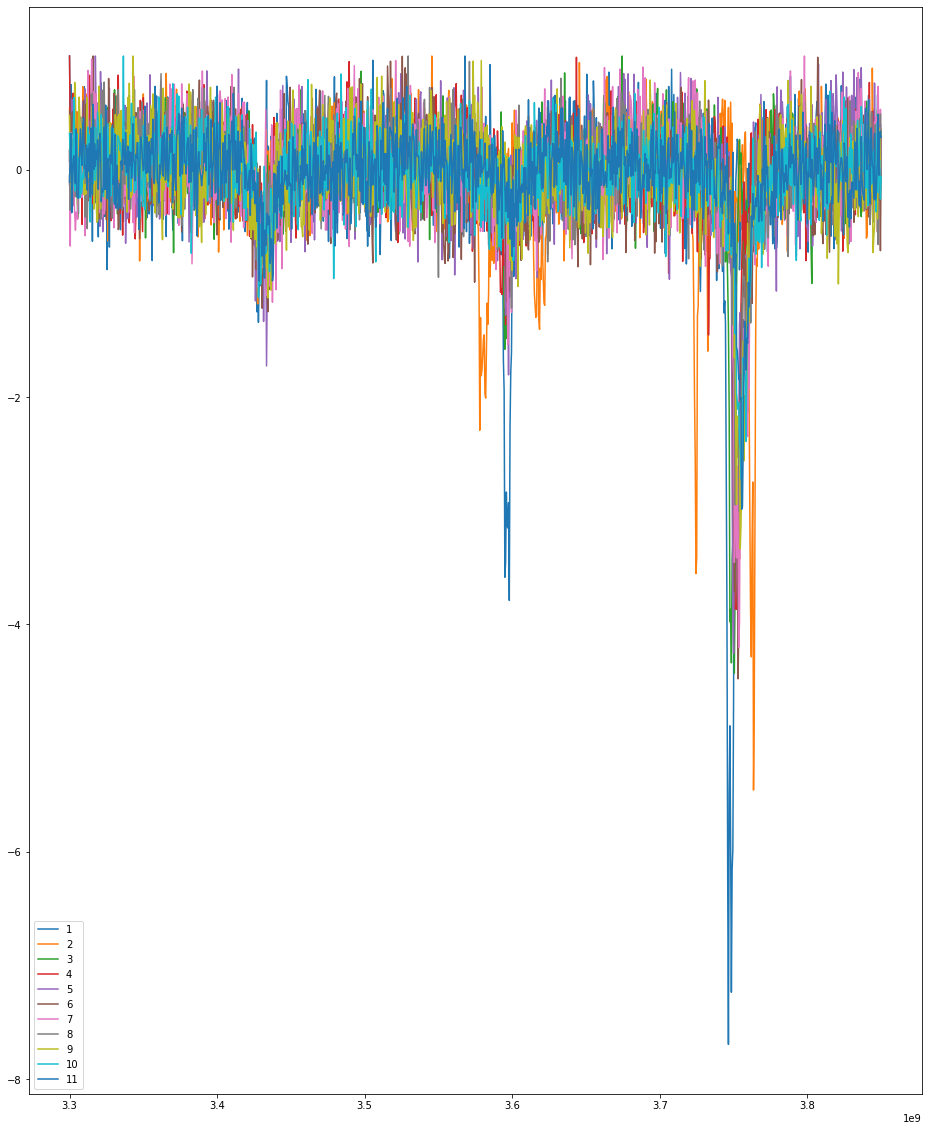

In [49]:
fig, axes = plt.subplots(1,1, figsize=(16, 20))
for i in range(11):
    axes.plot(y,all_measurements[i],label=str(i+1))
plt.legend()

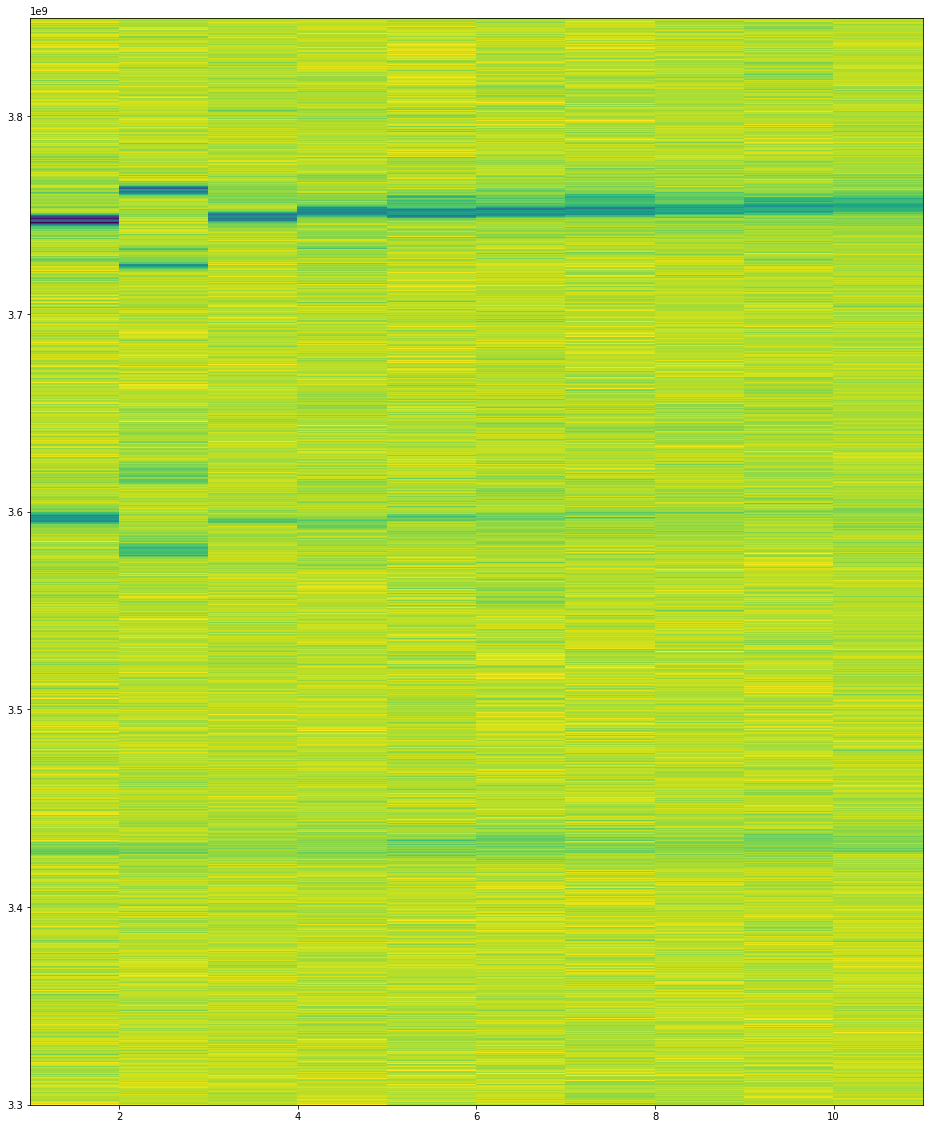

In [50]:
fig, axes = plt.subplots(1,1, figsize=(16, 20))
axes.pcolormesh(np.linspace(1,11,11),y,np.asarray(all_measurements).T)

In [69]:
%matplotlib qt5
from tqdm import tqdm

In [71]:
min_num_qubits = 1
max_num_qubits = 10
simulation_qubit_num = 11
all_measurements=[]
fig, axes = plt.subplots(max_num_qubits-min_num_qubits+1,1, figsize=(16, 20), sharex=True)
for num_qubits in tqdm(range(min_num_qubits,max_num_qubits+1)):
    try:
        m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power_paper', 
                                             metadata={'num_resonant_qubits': num_qubits,
                                                       'resonator_id':'1'})
    except:
        continue
        
    coil_voltages = {}
    for coil, voltage in m.metadata.items():
        if coil[:6] == 'NNDAC-':
            if int(coil[6:]) in coil_qubits.keys():
                coil_voltages[coil_qubits[int(coil[6:])]] = float(voltage)
    coil_voltages_vec = [coil_voltages[qubit_id] for qubit_id in coil_qubits.values()]
    
    qubit_frequencies = []
    for qubit_id_, qubit_id in enumerate(coil_qubits.values()):
        qubit_flux = (inductance_matrix@coil_voltages_vec)[qubit_id_]+params['phi0'][qubit_id]
        qubit_frequencies.append(fqbare(params['EJ1'][qubit_id], params['EJ2'][qubit_id], params['EC'], qubit_flux))
    
    #print(qubit_frequencies)
    
    #print (coil_voltages)
    simulation_qubit_num = num_qubits
    vals, vecs_ = simulate_non_driven_frequencies(simulation_qubit_num, qubit_frequencies[::-1], J2, J1)
    f01 = vals[1:simulation_qubit_num+1]-vals[0]
    f02h = np.asarray(vals[simulation_qubit_num+1:]-vals[0])/2
    
    try:
        x = m.datasets['S-parameter'].parameters[1].values
        y = m.datasets['S-parameter'].parameters[0].values
        z_cmplx = m.datasets['S-parameter'].data_squeezed
        med = np.median(np.real(z_cmplx))+1j*np.median(np.imag(z_cmplx))
        z_nomed = z_cmplx-med
        
        r = np.real(z_nomed.ravel())
        i = np.imag(z_nomed.ravel())
        
        m = np.asarray([[np.mean(r*r), np.mean(r*i)],[np.mean(r*i), np.mean(i*i)]])
        vals, vecs = np.linalg.eigh(m)
        best_index = np.argmax(vals)
        component = vecs[best_index,:]
        
        z = np.real(z_nomed*np.conj(component[0]+1j*component[1]))
        z = z/np.max(z)
        all_measurements.append(z)
#         plt.pcolormesh(x,y,z, cmap='Spectral_r')
        im = axes[num_qubits-min_num_qubits].plot(y,z)
        axes[num_qubits-min_num_qubits].set_xlim(3.55e9, 3.85e9)
#         plt.colorbar(im, ax=axes[num_qubits-min_num_qubits])
        for qubit_id in range(simulation_qubit_num):
            axes[num_qubits-min_num_qubits].axvline(f01[qubit_id], color='purple', linestyle=':', linewidth=3)
         
    except:
        raise
plt.savefig('two_tone_11q_power_1q_readout_1q_signal_1tone')
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 270.45it/s]


### readout of the 10 resonator with pump applied on the 11 qubit 

In [6]:
from tqdm import tqdm

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3876696313.520456, 3822947733.9470825, 4015772046.0845475, 3916840183.7858567, 3998926288.6972322, 3749851216.128782, 3749925776.7974086]


 10%|████████▎                                                                          | 1/10 [00:00<00:03,  2.26it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3876696313.520456, 3822947733.9470825, 4015772046.0845475, 3916221931.6115675, 3749228957.1599483, 3750177052.8802123, 3749925776.7974086]


 20%|████████████████▌                                                                  | 2/10 [00:00<00:03,  2.27it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3876696313.520456, 3822947733.9470825, 4013675310.6035166, 3747643185.6944814, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 30%|████████████████████████▉                                                          | 3/10 [00:01<00:03,  2.26it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3876696313.520456, 3822521873.922861, 3749596300.8648376, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 40%|█████████████████████████████████▏                                                 | 4/10 [00:01<00:02,  2.23it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3875797588.6973796, 3749639379.602891, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  2.10it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905074347.841985, 3748786496.613612, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.80it/s]

[4032242135.698283, 3878847324.858663, 3997094918.840846, 3749262812.0635324, 3749867143.935814, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:04,  1.46s/it]

[4032242135.698283, 3878716013.7978024, 3748677145.6831827, 3750172790.743899, 3749867143.935814, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:13<00:06,  3.18s/it]

[4031829870.648142, 3748047780.1208863, 3749813165.723134, 3750172790.743899, 3749867143.935814, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:49<00:13, 13.01s/it]

[3750035102.423915, 3750023305.7793055, 3749813165.723134, 3750172790.743899, 3749867143.935814, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:43<00:00, 61.32s/it]


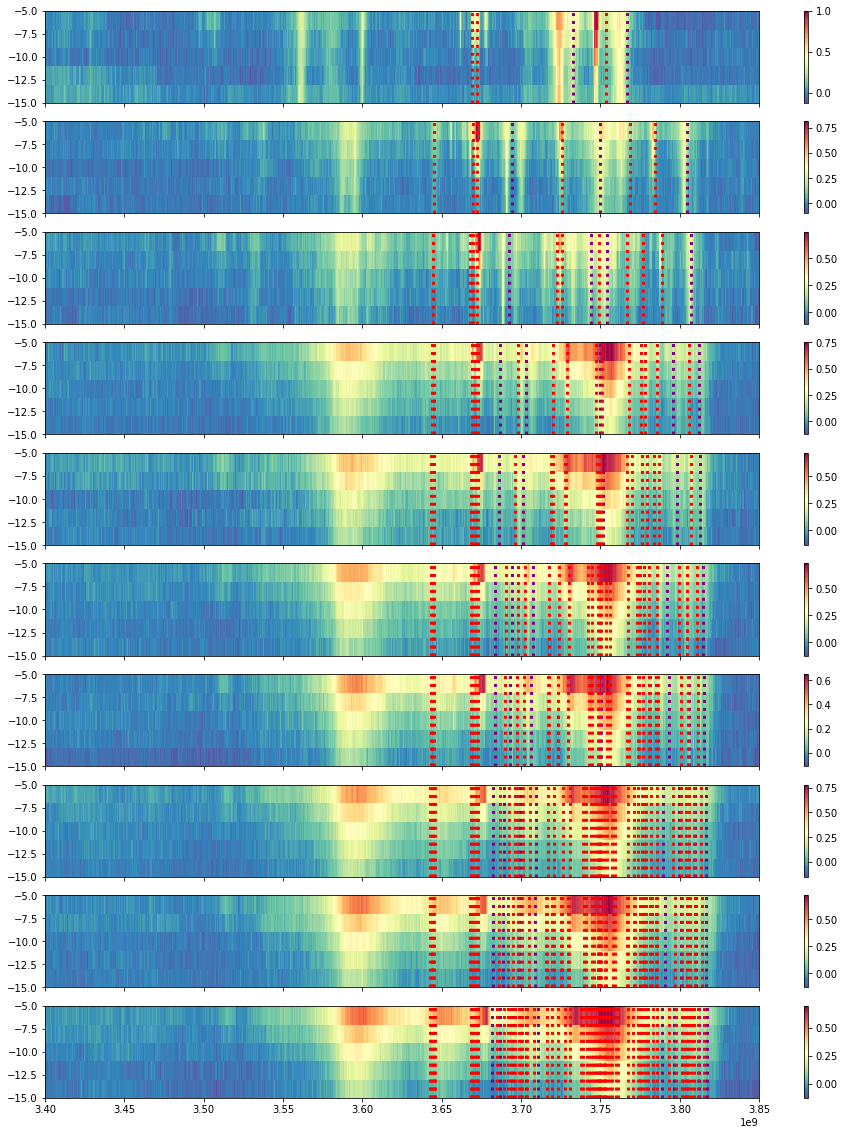

In [17]:
min_num_qubits = 2
max_num_qubits = 11
simulation_qubit_num = 11
fig, axes = plt.subplots(max_num_qubits-min_num_qubits+1,1, figsize=(16, 20), sharex=True)
for num_qubits in tqdm(range(min_num_qubits, max_num_qubits+1)):
    try:
        # Ivan : made 12-num
        m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power', 
                                             metadata={'num_resonant_qubits':12-num_qubits,
                                                       'resonator_id':'10'})
    except:
        raise
    coil_voltages = {}
    for coil, voltage in m.metadata.items():
        if coil[:6] == 'NNDAC-':
            if int(coil[6:]) in coil_qubits.keys():
                coil_voltages[coil_qubits[int(coil[6:])]] = float(voltage)
    coil_voltages_vec = [coil_voltages[qubit_id] for qubit_id in coil_qubits.values()]
    qubit_frequencies = []
    for qubit_id_, qubit_id in enumerate(coil_qubits.values()):
        qubit_flux = (inductance_matrix@coil_voltages_vec)[qubit_id_]+params['phi0'][qubit_id]
        qubit_frequencies.append(fqbare(params['EJ1'][qubit_id], params['EJ2'][qubit_id], params['EC'], qubit_flux))
    
    print(qubit_frequencies)
    
    #print (coil_voltages)
    simulation_qubit_num = num_qubits
    # Ivan : made reverse order
    vals, vecs_ = simulate_non_driven_frequencies(simulation_qubit_num, qubit_frequencies[::-1], J2, J1)
    f01 = vals[1:simulation_qubit_num+1]-vals[0]
#     print(f01)
    f02h = np.asarray(vals[simulation_qubit_num+1:]-vals[0])/2
    # thresholding by qubit 1 popluation
    #print ('Single-photon transitions:', f01)
    #print ('Two-photon transitions:', f02h)
    try:
        #m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power', metadata={'num_resonant_qubits':num_qubits})
        x = m.datasets['S-parameter'].parameters[1].values
        y = m.datasets['S-parameter'].parameters[0].values
        #z = np.abs(m.datasets['S-parameter'].data_squeezed)
        z_cmplx = m.datasets['S-parameter'].data_squeezed
        med = np.median(np.real(z_cmplx))+1j*np.median(np.imag(z_cmplx))
        z_nomed = z_cmplx-med
        
        r = np.real(z_nomed.ravel())
        i = np.imag(z_nomed.ravel())
        
        m = np.asarray([[np.mean(r*r), np.mean(r*i)],[np.mean(r*i), np.mean(i*i)]])
        vals, vecs = np.linalg.eigh(m)
        best_index = np.argmax(vals)
        component = vecs[best_index,:]
        
        z = np.real(z_nomed*np.conj(component[0]+1j*component[1]))
        z = z/np.max(z)
        
        im = axes[num_qubits-min_num_qubits].pcolormesh(x,y,z, cmap='Spectral_r')
        axes[num_qubits-min_num_qubits].set_xlim(3.4e9, 3.85e9)
        plt.colorbar(im, ax=axes[num_qubits-min_num_qubits])
        #axes[num_qubits-min_num_qubits].scatter(np.real(z), np.imag(z))
        for qubit_id in range(simulation_qubit_num):
            axes[num_qubits-min_num_qubits].axvline(f01[qubit_id], color='purple', linestyle=':', linewidth=3)
            
        for transition_id in range((simulation_qubit_num*(simulation_qubit_num+1)//2)):
            axes[num_qubits-min_num_qubits].axvline(f02h[transition_id], color='red', linestyle=':', linewidth=3)
        
        #if num_qubits % 2:
        #    probabilities = np.abs(vecs_[(num_qubits+1)//2])**2
        #    populations = []
        #    for qubit_id in range(num_qubits):
                
        #    populations.append(np.reshape(probabilities, probabilities.dims[0])[
        #    ,...])
        #    probabilities = 
        #    axes[num_qubits-min_num_qubits,1].bar()
        
    except:
        raise
plt.savefig('two_tone_11q_power_10q_readout_11q_signal')
plt.show()

### readout of the 11 resonator with pump applied on the 11 qubit 

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3876696313.520456, 3822947733.9470825, 4015772046.0845475, 3916840183.7858567, 3998926288.6972322, 3749851216.128782, 3749925776.7974086]


 10%|████████▎                                                                          | 1/10 [00:00<00:03,  2.33it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3876696313.520456, 3822947733.9470825, 4015772046.0845475, 3916221931.6115675, 3749228957.1599483, 3750177052.8802123, 3749925776.7974086]


 20%|████████████████▌                                                                  | 2/10 [00:00<00:03,  2.32it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3876696313.520456, 3822947733.9470825, 4013675310.6035166, 3747643185.6944814, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 30%|████████████████████████▉                                                          | 3/10 [00:01<00:03,  2.28it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3876696313.520456, 3822521873.922861, 3749596300.8648376, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 40%|█████████████████████████████████▏                                                 | 4/10 [00:01<00:02,  2.23it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3875797588.6973796, 3749639379.602891, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  2.08it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905074347.841985, 3748786496.613612, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.83it/s]

[4032242135.698283, 3878847324.858663, 3997094918.840846, 3749262812.0635324, 3749867143.935814, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:04,  1.53s/it]

[4032242135.698283, 3878716013.7978024, 3748677145.6831827, 3750172790.743899, 3749867143.935814, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:14<00:06,  3.47s/it]

[4031829870.648142, 3748047780.1208863, 3749813165.723134, 3750172790.743899, 3749867143.935814, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:00<00:16, 16.17s/it]

[3750035102.423915, 3750023305.7793055, 3749813165.723134, 3750172790.743899, 3749867143.935814, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:56<00:00, 64.10s/it]


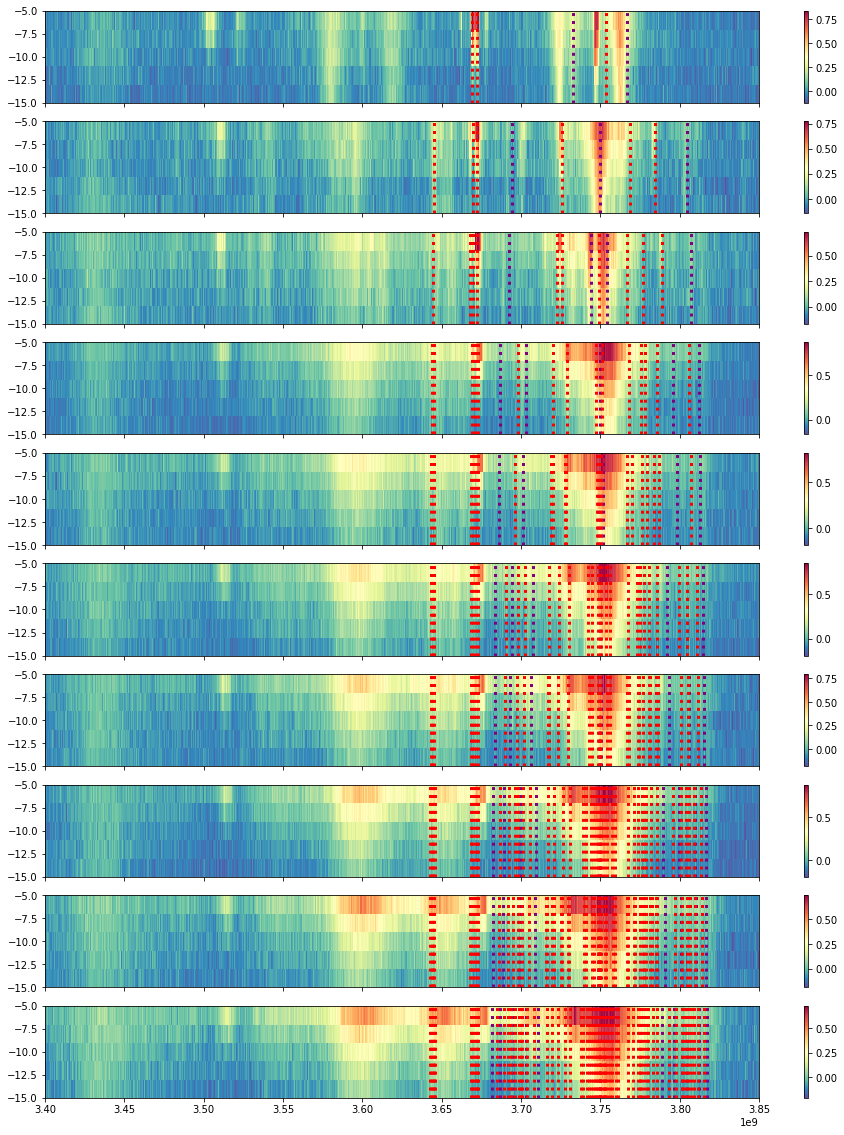

In [16]:
min_num_qubits = 2
max_num_qubits = 11
simulation_qubit_num = 11
fig, axes = plt.subplots(max_num_qubits-min_num_qubits+1,1, figsize=(16, 20), sharex=True)
for num_qubits in tqdm(range(min_num_qubits, max_num_qubits+1)):
    try:
        # Ivan : made 12-num
        m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power', 
                                             metadata={'num_resonant_qubits':12-num_qubits,
                                                       'resonator_id':'11'})
    except:
        raise
    coil_voltages = {}
    for coil, voltage in m.metadata.items():
        if coil[:6] == 'NNDAC-':
            if int(coil[6:]) in coil_qubits.keys():
                coil_voltages[coil_qubits[int(coil[6:])]] = float(voltage)
    coil_voltages_vec = [coil_voltages[qubit_id] for qubit_id in coil_qubits.values()]
    qubit_frequencies = []
    for qubit_id_, qubit_id in enumerate(coil_qubits.values()):
        qubit_flux = (inductance_matrix@coil_voltages_vec)[qubit_id_]+params['phi0'][qubit_id]
        qubit_frequencies.append(fqbare(params['EJ1'][qubit_id], params['EJ2'][qubit_id], params['EC'], qubit_flux))
    
    print(qubit_frequencies)
    
    #print (coil_voltages)
    simulation_qubit_num = num_qubits
    # Ivan : made reverse order
    vals, vecs_ = simulate_non_driven_frequencies(simulation_qubit_num, qubit_frequencies[::-1], J2, J1)
    f01 = vals[1:simulation_qubit_num+1]-vals[0]
#     print(f01)
    f02h = np.asarray(vals[simulation_qubit_num+1:]-vals[0])/2
    # thresholding by qubit 1 popluation
    #print ('Single-photon transitions:', f01)
    #print ('Two-photon transitions:', f02h)
    try:
        #m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power', metadata={'num_resonant_qubits':num_qubits})
        x = m.datasets['S-parameter'].parameters[1].values
        y = m.datasets['S-parameter'].parameters[0].values
        #z = np.abs(m.datasets['S-parameter'].data_squeezed)
        z_cmplx = m.datasets['S-parameter'].data_squeezed
        med = np.median(np.real(z_cmplx))+1j*np.median(np.imag(z_cmplx))
        z_nomed = z_cmplx-med
        
        r = np.real(z_nomed.ravel())
        i = np.imag(z_nomed.ravel())
        
        m = np.asarray([[np.mean(r*r), np.mean(r*i)],[np.mean(r*i), np.mean(i*i)]])
        vals, vecs = np.linalg.eigh(m)
        best_index = np.argmax(vals)
        component = vecs[best_index,:]
        
        z = np.real(z_nomed*np.conj(component[0]+1j*component[1]))
        z = z/np.max(z)
        
        im = axes[num_qubits-min_num_qubits].pcolormesh(x,y,z, cmap='Spectral_r')
        axes[num_qubits-min_num_qubits].set_xlim(3.4e9, 3.85e9)
        plt.colorbar(im, ax=axes[num_qubits-min_num_qubits])
        #axes[num_qubits-min_num_qubits].scatter(np.real(z), np.imag(z))
        for qubit_id in range(simulation_qubit_num):
            axes[num_qubits-min_num_qubits].axvline(f01[qubit_id], color='purple', linestyle=':', linewidth=3)
            
        for transition_id in range((simulation_qubit_num*(simulation_qubit_num+1)//2)):
            axes[num_qubits-min_num_qubits].axvline(f02h[transition_id], color='red', linestyle=':', linewidth=3)
        
        #if num_qubits % 2:
        #    probabilities = np.abs(vecs_[(num_qubits+1)//2])**2
        #    populations = []
        #    for qubit_id in range(num_qubits):
                
        #    populations.append(np.reshape(probabilities, probabilities.dims[0])[
        #    ,...])
        #    probabilities = 
        #    axes[num_qubits-min_num_qubits,1].bar()
        
    except:
        raise
plt.savefig('two_tone_11q_power_11q_readout_11q_signal')    
plt.show()

In [28]:
def data_processing(resonator_id,num_resonant_qubits=11,mtype='two_tone_11q_power_paper'):
    m = exdir_db_inst.select_measurement(measurement_type=mtype, 
                                                 metadata={'num_resonant_qubits': num_resonant_qubits,
                                                           'resonator_id':resonator_id})
    x = m.datasets['S-parameter'].parameters[1].values
    y = m.datasets['S-parameter'].parameters[0].values
    z_cmplx = m.datasets['S-parameter'].data_squeezed
    med = np.median(np.real(z_cmplx))+1j*np.median(np.imag(z_cmplx))
    z_nomed = z_cmplx-med

    r = np.real(z_nomed.ravel())
    i = np.imag(z_nomed.ravel())

    m = np.asarray([[np.mean(r*r), np.mean(r*i)],[np.mean(r*i), np.mean(i*i)]])
    vals, vecs = np.linalg.eigh(m)
    best_index = np.argmax(vals)
    component = vecs[best_index,:]

    z = np.real(z_nomed*np.conj(component[0]+1j*component[1]))
    z = z/np.max(z)
    return y,z

построить одномерные
скатер плот
в симуляции лоу энерджи сабспейс


In [33]:
from scipy.signal import savgol_filter

In [78]:
fig, axes = plt.subplots(5,1, figsize=(8, 8), sharex=True)
x1,y1=data_processing('11','11',mtype='two_tone_11q_power_paper')
# x2,y2=data_processing('6','11',mtype='two_tone_11q_power_paper')
x2,y2=data_processing('1','11',mtype='two_tone_11q_power_paper')
x3,y3=data_processing('11','11',mtype='two_tone_11q_1q_power_paper')
x4,y4=data_processing('1','10',mtype='two_tone_11q_1q_power_paper')
x5,y5=data_processing('1','11',mtype='two_tone_11q_1q_power_paper')
points=500
axes[0].plot(x1[points:],y1[points:])
axes[1].plot(x2[points:],y2[points:])
axes[2].plot(x3[points:],y3[points:])
axes[3].plot(x4[points:],y4[points:])
axes[4].plot(x5[points:],y5[points:])
plt.plot()

[]

In [77]:
%matplotlib qt5

In [75]:
np.std(y4[:500])

0.2582344648521313

In [76]:
np.min(y4)

-1.9804615348696684

In [ ]:
x4,y4=data_processing('1','11',mtype='two_tone_11q_1q_power_paper')


In [34]:
x,y,z=data_processing('11','11',mtype='two_tone_11q_power_paper')

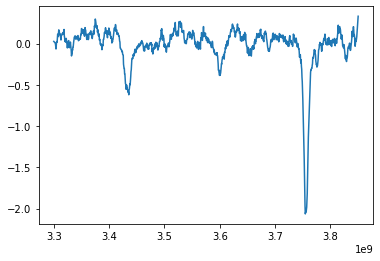

In [40]:
plt.plot(y,savgol_filter(z,11,1))

In [47]:
x,y,z=data_processing('1','11',mtype='two_tone_11q_power_paper')

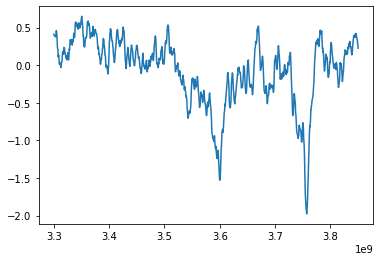

In [48]:
plt.plot(y,savgol_filter(z,15,2))

In [55]:
x,y,z=data_processing('11','11',mtype='two_tone_11q_1q_power_paper')

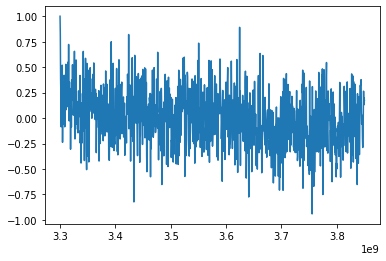

In [56]:
plt.plot(y,z)

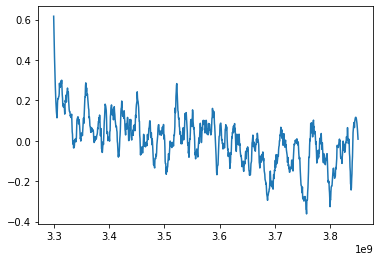

In [54]:
plt.plot(y,savgol_filter(z,25,2))

In [42]:
x,y,z=data_processing('1','10',mtype='two_tone_11q_1q_power_paper')

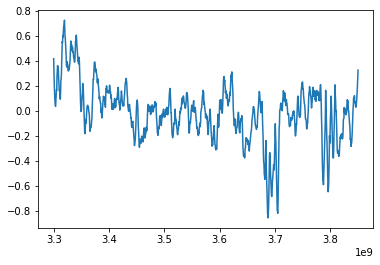

In [46]:
plt.plot(y,savgol_filter(z,15,2))

In [31]:
x,y,z=data_processing('1','11',mtype='two_tone_11q_1q_power_paper')

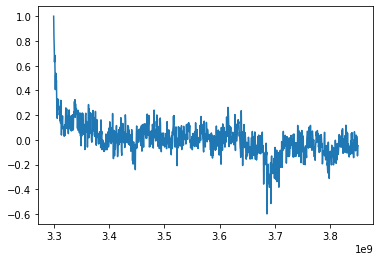

In [32]:
plt.plot(y,z)

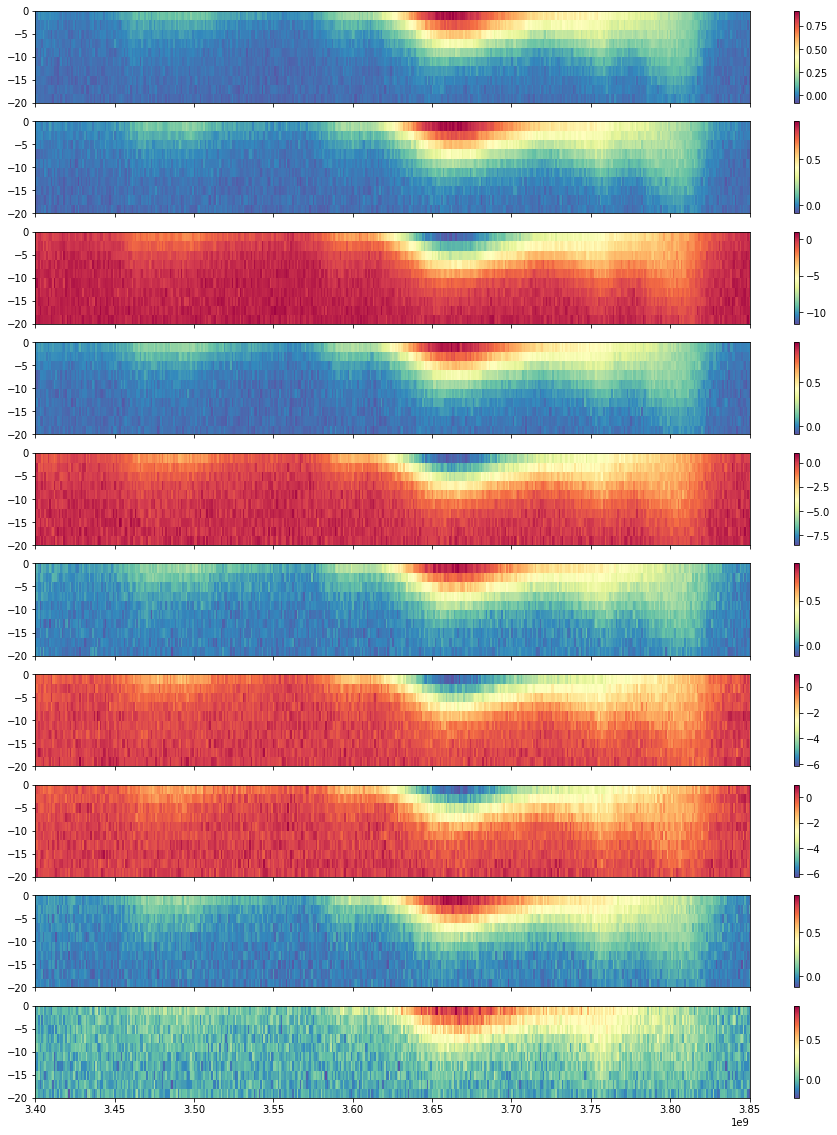

In [123]:
fig, axes = plt.subplots(10,1, figsize=(16, 20), sharex=True)
for i in range(2,12):
#     print(i+2)
    x,y,z=data_processing(str(i))
    im = axes[i-2].pcolormesh(x,y,z, cmap='Spectral_r')
    axes[i-2].set_xlim(3.4e9, 3.85e9)
    plt.colorbar(im, ax=axes[i-2])
plt.savefig('two_tone_11q_power_signal_everywhere')    
plt.show()

In [101]:
x,y,z=data_processing('11')

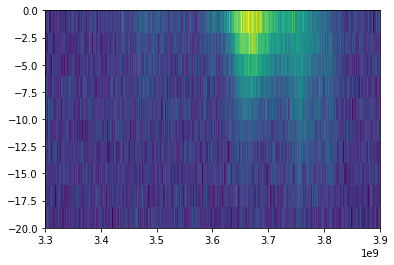

In [102]:
plt.pcolormesh(x,y,z)

(3720000000.0, 3800000000.0)

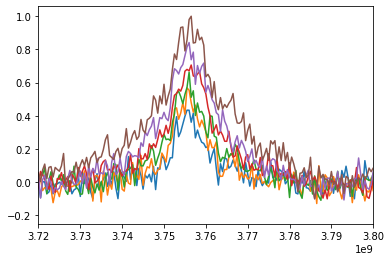

In [87]:
for i in range(len(z)):
    plt.plot(x,z[i])
plt.xlim(3.72e9,3.8e9)

In [88]:
x,y,z=data_processing('9')

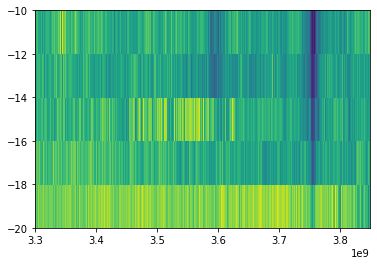

In [89]:
plt.pcolormesh(x,y,z)

(3720000000.0, 3800000000.0)

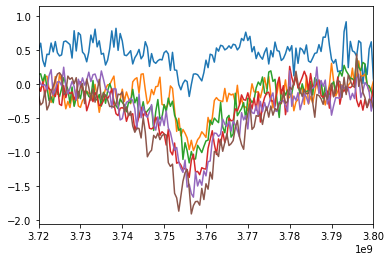

In [90]:
for i in range(len(z)):
    plt.plot(x,z[i])
plt.xlim(3.72e9,3.8e9)

In [25]:
def data_load(resonator_id,num_resonant_qubits=11,mtype='two_tone_11q_power_paper'):
    m = exdir_db_inst.select_measurement(measurement_type=mtype, 
                                                 metadata={'num_resonant_qubits': num_resonant_qubits,
                                                           'resonator_id':resonator_id})
    x = m.datasets['S-parameter'].parameters[1].values
    y = m.datasets['S-parameter'].parameters[0].values
    z_cmplx = m.datasets['S-parameter'].data_squeezed
    med = np.median(np.real(z_cmplx))+1j*np.median(np.imag(z_cmplx))
    z_nomed = z_cmplx-med

    r = np.real(z_nomed.ravel())
    i = np.imag(z_nomed.ravel())

    m = np.asarray([[np.mean(r*r), np.mean(r*i)],[np.mean(r*i), np.mean(i*i)]])
    vals, vecs = np.linalg.eigh(m)
    best_index = np.argmax(vals)
    component = vecs[best_index,:]

    z = np.abs(z_nomed*np.conj(component[0]+1j*component[1]))
    z = z/np.max(z)
    return x,y,z

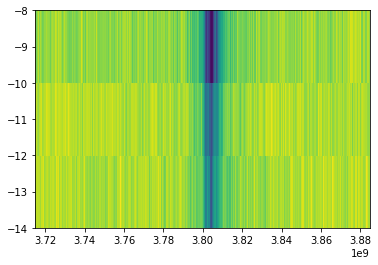

In [11]:
num_qubits=11
resonator_id=11
x,y,z=data_load(resonator_id=resonator_id, num_resonant_qubits=num_qubits, mtype='two_tone_11q_power_scan_3_8fr')

plt.pcolormesh(x,y,z)





In [40]:
x,y,z=data_load(resonator_id=10, num_resonant_qubits=11, mtype='two_tone_11q_power_scan_3_8fr')


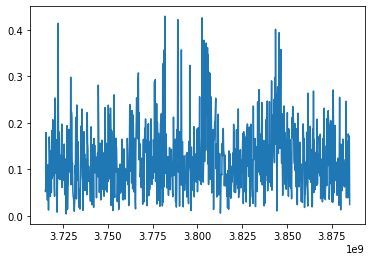

In [41]:
plt.plot(x,np.real(z[0,:]))

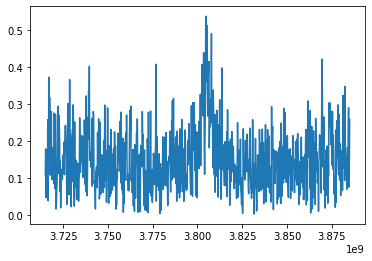

In [39]:
plt.plot(x,np.real(z[0,:]))

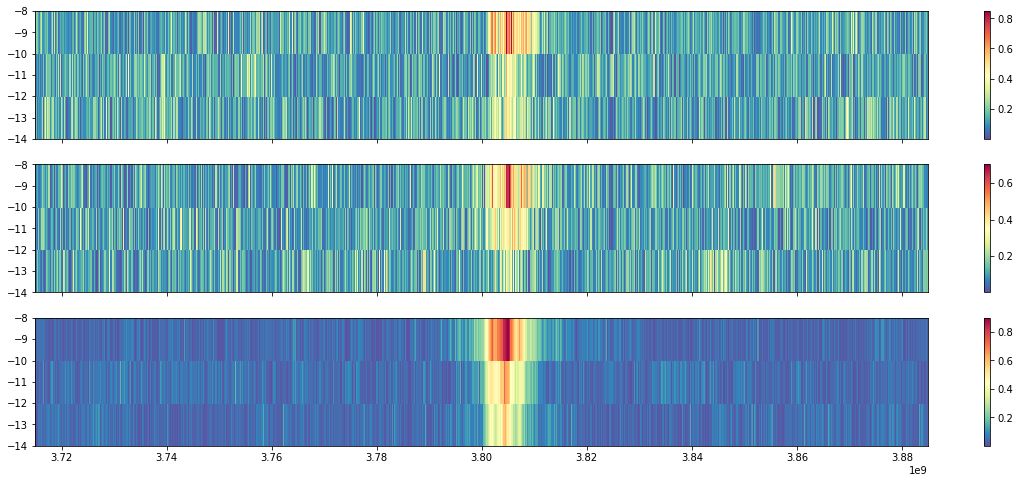

In [26]:
fig, axes = plt.subplots(3,1, figsize=(20, 8), sharex=True)
for rez_id in range(9,12):
    num_qubits=11
    x,y,z=data_load(resonator_id=rez_id, num_resonant_qubits=num_qubits, mtype='two_tone_11q_power_scan_3_8fr')
    im = axes[rez_id-9].pcolormesh(x,y,z, cmap='Spectral_r')
    axes[rez_id-9].set_xlim(x[0], x[-1])
    plt.colorbar(im, ax=axes[rez_id-9])
plt.savefig('two_tone_11q_power_signal_everywhere')    
plt.show()

In [33]:
np.asarray([1,9,10,11])[0]

1

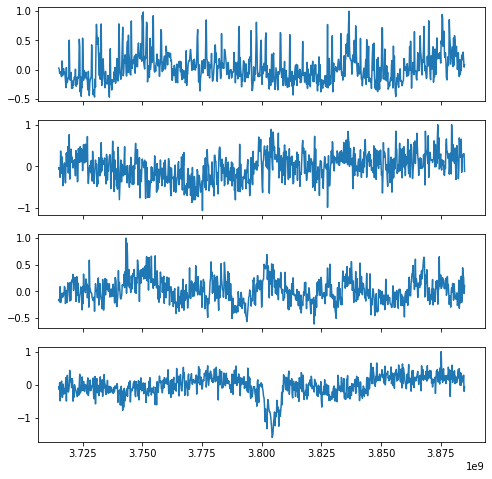

In [34]:
fig, axes = plt.subplots(4,1, figsize=(8, 8), sharex=True)
for _id,rez_id in enumerate(np.asarray([1,9,10,11])):
    num_qubits=11
    y,z=data_processing(resonator_id=rez_id, num_resonant_qubits=num_qubits, mtype='two_tone_11q_11q_power_bands_3_8fr')
    axes[_id].plot(y,z)
    
#plt.savefig('two_tone_11q_power_signal_everywhere')    
plt.show()

In [40]:
def data_ex(prep=True):
    m = exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                                 metadata={'num_resonant_qubits': 1,
                                                           'resonator_id':'1',
                                                          'ex_qubit': '1'})
    x = m.datasets['S-parameter'].parameters[1].values
    y = m.datasets['S-parameter'].parameters[0].values
    if prep==True:
        z_cmplx = m.datasets['S-parameter'].data_squeezed
        med = np.median(np.real(z_cmplx))+1j*np.median(np.imag(z_cmplx))
        z_nomed = z_cmplx-med

        r = np.real(z_nomed.ravel())
        i = np.imag(z_nomed.ravel())

        m = np.asarray([[np.mean(r*r), np.mean(r*i)],[np.mean(r*i), np.mean(i*i)]])
        vals, vecs = np.linalg.eigh(m)
        best_index = np.argmax(vals)
        component = vecs[best_index,:]

        z = np.abs(z_nomed*np.conj(component[0]+1j*component[1]))
        z = z/np.max(z)
    else:
        z=m.datasets['S-parameter'].data
        med = np.median(np.real(z))+1j*np.median(np.imag(z))
        z= z-med
    return x,y/1e9, np.abs(z),m

## Plot pic

In [13]:
%matplotlib qt5

In [41]:
def data_ex(num_qubits, power=-20):
    m = exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                                 metadata={'num_resonant_qubits': num_qubits,
                                                           'resonator_id':'1',
                                                           'ex_qubit': '1',
                                                           'pump_power': power})
    x = m.datasets['S-parameter'].parameters[1].values
    y = m.datasets['S-parameter'].parameters[0].values
    z=m.datasets['S-parameter'].data
#         med = np.median(np.real(z))+1j*np.median(np.imag(z))
#         z= z-med
    return x,y, z,m

In [61]:
def fit_freqs(m,simulation_qubit_num):
    coil_voltages = {}
    for coil, voltage in m.metadata.items():
        if coil[:6] == 'NNDAC-':
            if int(coil[6:]) in coil_qubits.keys():
                coil_voltages[coil_qubits[int(coil[6:])]] = float(voltage)
    coil_voltages_vec = [coil_voltages[qubit_id] for qubit_id in coil_qubits.values()]
    
    qubit_frequencies = []
    for qubit_id_, qubit_id in enumerate(coil_qubits.values()):
        qubit_flux = (inductance_matrix@coil_voltages_vec)[qubit_id_]+params['phi0'][qubit_id]
        qubit_frequencies.append(fqbare(params['EJ1'][qubit_id], params['EJ2'][qubit_id], params['EC'], qubit_flux))
    vals, vecs_ = simulate_non_driven_frequencies(simulation_qubit_num, qubit_frequencies, J1, J2)
    f01 = vals[1:simulation_qubit_num+1]-vals[0]
    f02h = np.asarray(vals[simulation_qubit_num+1:]-vals[0])/2
    return f01,f02h



  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

  9%|███████▌                                                                           | 1/11 [00:00<00:04,  2.33it/s]

 18%|███████████████                                                                    | 2/11 [00:00<00:03,  2.31it/s]

 27%|██████████████████████▋                                                            | 3/11 [00:01<00:03,  2.12it/s]

 36%|██████████████████████████████▏                                                    | 4/11 [00:01<00:03,  2.15it/s]

 45%|█████████████████████████████████████▋                                             | 5/11 [00:02<00:02,  2.13it/s]

 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:02<00:02,  2.06it/s]

 64%|████████████████████████████████████████████████████▊                              | 7/11 [00:03<00:02,  1.87it/s]

 73%|█████████████████████████

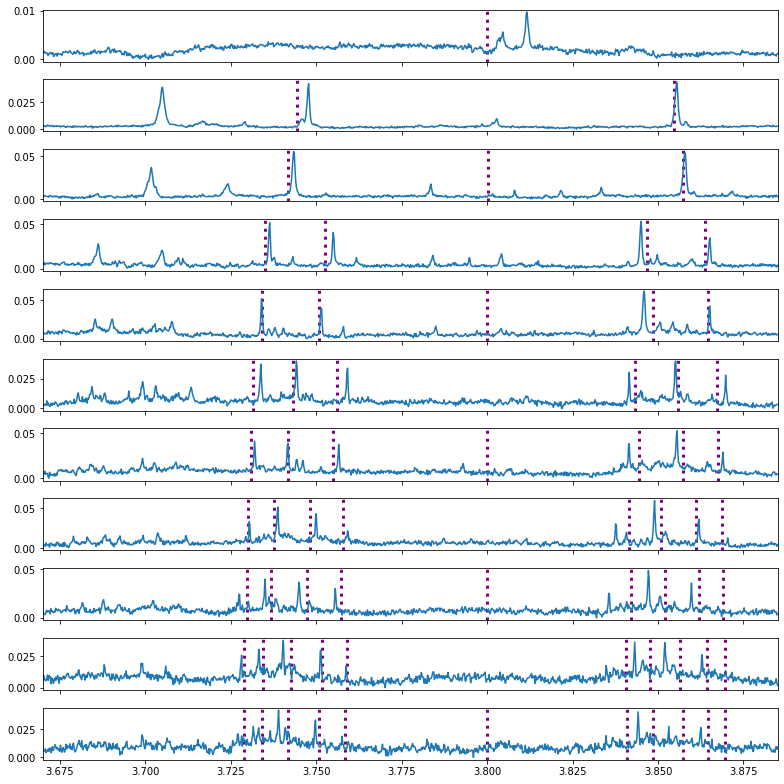

In [156]:
from matplotlib.ticker import (AutoMinorLocator)
num_qubits = 11
figs, axes = plt.subplots(num_qubits,1, sharex=True, sharey=False, figsize=(11,11))
for nq in tqdm(range(1, num_qubits+1)):
#     try:
#         x1,y1,z1,m=data_ex(nq, '0.0')
#         f01,f02h=fit_freqs(m,nq)
#     except: 
#         print ('Failed 0dbm loading for ',nq, ' qubits')
#         pass
    try:
        x2,y2,z2,m=data_ex(nq, '-20.0')
        f01,f02h=fit_freqs(m,nq)
    except: 
        print ('Failed -20dbm loading for ',nq, ' qubits')
        pass

    
    baseline1 = np.min(np.abs(np.mean(z1, axis=0)))
    baseline2 = np.min(np.abs(np.mean(z2, axis=0)))
    for qubit_id in range(nq):
        axes[nq-1].axvline(f01[qubit_id]/1e9, color='purple', linestyle=':', linewidth=3)
            
#     for transition_id in range((nq*(nq+1)//2)):
#         if True:#3.675<f02h[transition_id]/1e9<3.75:
#             axes[nq-1].axvline(f02h[transition_id]/1e9, color='red', linestyle=':', linewidth=3)
#     axes[nq-1].plot(x1/1e9, (np.abs(np.mean(z1, axis=0))-baseline1))
    axes[nq-1].plot(x2/1e9, (np.abs(np.mean(z2, axis=0))-baseline2)*nq)
    axes[nq-1].set_xlim(3.67, 3.885)
    #axes[nq-1].xaxis.set_minor_locator(AutoMinorLocator())
    #axes[nq-1].tick_params(which='both', width=3)
    #axes[nq-1].tick_params(which='major', length=12, labelsize=10)
    #axes[nq-1].tick_params(which='minor', length=6, color='r')

plt.tight_layout()
# plt.savefig(r'D:\data\2019-12-21\summary-11q-plot-wrong.svg')
# plt.savefig(r'D:\data\2019-12-21\summary-11q-plot-wrong.png')

In [157]:
figs.savefig(r'D:\data\2019-12-30\summary-11q-plot_not_shared_y_low_power.svg')

In [79]:
plt.show()

In [149]:
def data_ex_11q(resonator_id):
    m = exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                                 metadata={'num_resonant_qubits': '11',
                                                           'resonator_id':str(resonator_id),
                                                           'ex_qubit': '11',
                                                           'lo_attenuation': -30,
                                                          'pump_power':'-15.0'})
#     m= exdir_db_inst.select_measurement_by_id(5573)
    x = m.datasets['S-parameter'].parameters[1].values
    y = m.datasets['S-parameter'].parameters[0].values
    z=m.datasets['S-parameter'].data
    return x,y, z,m

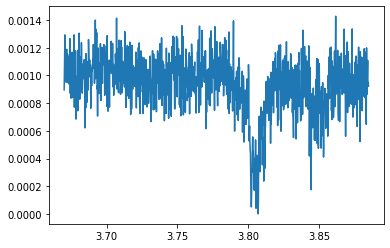

In [153]:
x,y,z,m = data_ex_11q(10)
baseline = np.min(np.abs(np.mean(z, axis=0)))
plt.plot(x/1e9, (np.abs(np.mean(z, axis=0))-baseline))

<IPython.core.display.Javascript object>


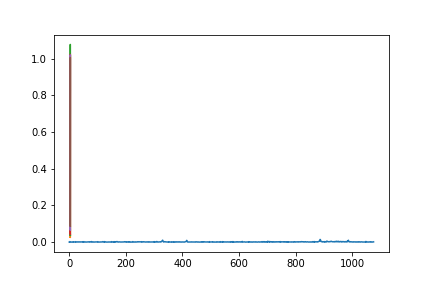

In [150]:
plot(range(len(z)),z)

In [ ]:
250:460,
840:1080   

In [100]:
z.shape

(1076,)

In [171]:
z=z.reshape((1076,))

[2.64363496e-02 3.78139745e+00 9.93882090e-01 4.94565673e-04]


<IPython.core.display.Javascript object>


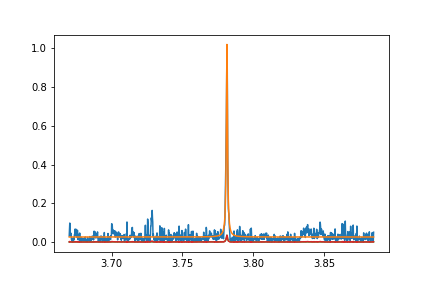

In [172]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import leastsq

def lorentzian( x, x0, a, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)

def multi_lorentz( x, params ):
    off = params[0]
    paramsRest = params[1:]
    assert not ( len( paramsRest ) % 3 )
    return off + sum( [ lorentzian( x, *paramsRest[ i : i+3 ] ) for i in range( 0, len( paramsRest ), 3 ) ] )

def res_multi_lorentz( params, xData, yData ):
    diff = [ multi_lorentz( x, params ) - y for x, y in zip( xData, yData ) ]
    return diff

xData, yData = y,z
yData = yData / max(yData)

generalWidth = 3.17136922e-04

yDataLoc = yData
startValues = [ max( yData ) ]
counter = 0

while max( yDataLoc ) - min( yDataLoc ) > .1:
    counter += 1
    if counter > 1: ### max 20 peak...emergency break to avoid infinite loop
        break
    minP = np.argmax( yDataLoc )
    minY = yData[ minP ]
    x0 = xData[ minP ]
    startValues += [ x0, minY - min( yDataLoc ), generalWidth ]
    popt, ier = leastsq( res_multi_lorentz, startValues, args=( xData, yData ) )
    yDataLoc = [ y - multi_lorentz( x, popt ) for x,y in zip( xData, yData ) ]

print(popt)
testData = [ multi_lorentz(x, popt ) for x in xData ]

fig = plt.figure()
ax = fig.add_subplot( 1, 1, 1 )
ax.plot( xData, yData )
ax.plot( xData, testData )
plt.show()

In [20]:
%matplotlib qt5

In [30]:
plot(y[250:],z[250:])

In [131]:
a1=[2.64363648e-02, 3.78139745e+00, 9.93884150e-01, 4.94563591e-04] # last is gamma  4.94563591e-04

<IPython.core.display.Javascript object>


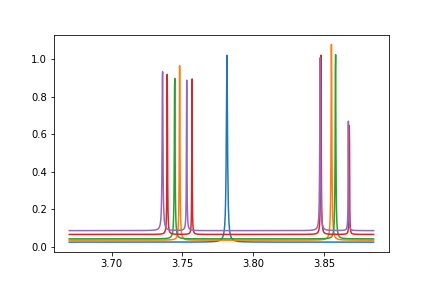

In [157]:
plt.plot(y,[multi_lorentz(x, a1) for x in y ])
plt.plot(y,[multi_lorentz(x, a2) for x in y ])
plt.plot(y,[multi_lorentz(x, a3) for x in y ])
plt.plot(y,[multi_lorentz(x, a4) for x in y ])
plt.plot(y,[multi_lorentz(x, a5) for x in y ])

<IPython.core.display.Javascript object>


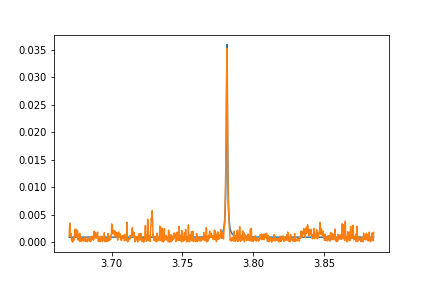

In [176]:
plt.plot(y,[multi_lorentz(x, a1) for x in y ])
plt.plot(y,z)

In [173]:
max(z)

0.03522066574244788

In [174]:
a1=[2.64363496e-02*0.03522066574244788, 3.78139745e+00, 9.93882090e-01*0.03522066574244788, 4.94565673e-04]

In [132]:
a2=[3.67442798e-02 ,3.85525167e+00, 1.06690054e+00 ,3.30212318e-04,
 3.74799165e+00, 9.28634381e-01, 2.83089821e-04]# 3.30212318e-04,2.83089821e-04

In [133]:
a3=[4.37806871e-02, 3.85811973e+00 ,1.05578427e+00 ,2.88013853e-04,
 3.74451336e+00, 9.27062933e-01, 2.95322251e-04]

In [141]:
a4=[6.73115306e-02, 3.84779356e+00, 9.54437013e-01, 2.32752155e-04,
 3.73926861e+00, 9.42069651e-01, 2.10097496e-04, 3.75673123e+00,
 1.00804055e+00, 1.46990489e-04, 3.86788733e+00, 7.72504500e-01,
 1.50993278e-04]

In [144]:
a5=[8.75302348e-02, 3.73590831e+00, 9.13636418e-01, 3.22092569e-04,
 3.75298243e+00, 8.05889416e-01,2.06965673e-04, 1.15859063e-01, 
 3.84726605e+00, 9.66238920e-01, 2.92580590e-04,
 3.86720645e+00, 5.82949777e-01,1.85730095e-04]

In [166]:
a5=[8.75302348e-02*0.010770743911496903, 3.73590831e+00, 9.13636418e-01*0.010770743911496903, 3.22092569e-04,
 3.75298243e+00, 8.05889416e-01*0.010770743911496903, 2.06965673e-04, 3.84726605e+00, 9.66238920e-01*0.014516710076938166, 2.92580590e-04,
 3.86720645e+00, 5.82949777e-01*0.014516710076938166, 1.85730095e-04]

In [ ]:
250:460, for 5qubits
840:1080 